In [5]:
! pip install deap



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Mohammad Reza\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Synthetic data generated.
GA Best Sortino Ratio: 21.9509
SA Best Sortino Ratio: 0.7125
MET 3 Best Sortino Ratio: 3.8353


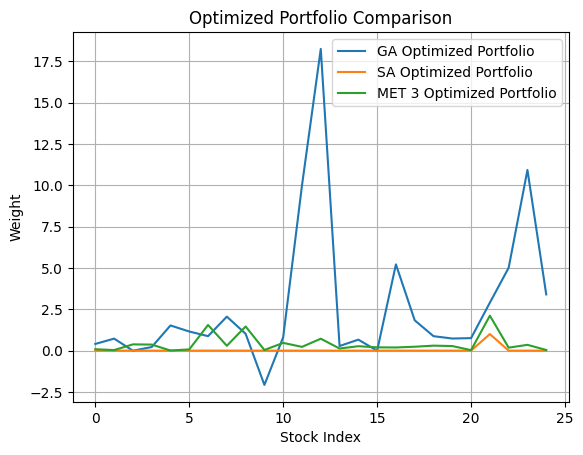

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
import time
import os

# Constants
DATA_FOLDER = 'DATA'
NUM_SHARE = 25  
NUM_CHROM = 50  
NUM_ITER = 100  
MU_TARGET = 0.001 
DAYS = 252 * 7  

# Seed for reproducibility
random.seed(42)
np.random.seed(42)

def load_and_generate_synthetic_data(data_folder):
    stock_files = [f for f in os.listdir(data_folder) if f.endswith('.txt')]
    if not stock_files:
        raise FileNotFoundError(f"No .txt files found in the directory: {data_folder}")
    
    stock_names = [f.split('.')[0] for f in stock_files][:NUM_SHARE]
    dates = pd.date_range(end=pd.Timestamp.today(), periods=DAYS, freq='B')
    
    data = {}
    
    for name in stock_names:
        open_prices = np.random.normal(loc=100, scale=30, size=DAYS)
        close_prices = open_prices + np.random.normal(loc=0, scale=5, size=DAYS)
        high_prices = np.maximum(open_prices, close_prices) + np.random.normal(loc=0, scale=3, size=DAYS)
        low_prices = np.minimum(open_prices, close_prices) - np.random.normal(loc=0, scale=3, size=DAYS)
        volume = np.random.randint(1000, 10000, size=DAYS)
        
        df = pd.DataFrame({
            'Ticker': name,
            'Per': 'd',
            'DTYYYYMMDD': dates.strftime('%Y%m%d'),
            'TIME': '000000',  
            'Open': open_prices,
            'High': high_prices,
            'Low': low_prices,
            'Close': close_prices,
            'Vol': volume,
            'Openint': 0  
        })
        
        data[name] = df

    all_data = pd.concat(data.values(), ignore_index=True)
    
    all_data['Date'] = pd.to_datetime(all_data['DTYYYYMMDD'], format='%Y%m%d')
    all_data.set_index('Date', inplace=True)
    
    close_prices = all_data.pivot_table(index='Date', columns='Ticker', values='Close')
    returns = close_prices.pct_change().dropna()

    return returns

def calculate_sortino_ratio(weights, returns, target=MU_TARGET/252):
    portfolio_return = np.dot(weights, returns.mean()) * 252  
    downside = returns.copy()
    downside[downside > target] = 0
    downside_risk = np.sqrt((downside ** 2).sum(axis=1).mean()) * np.sqrt(252)

    if downside_risk == 0:
        return 0
    return (portfolio_return - target * 252) / downside_risk

def evaluate(individual, returns):
    weights = np.array(individual)
    sortino = calculate_sortino_ratio(weights, returns)
    return (sortino,)

# Simulated Annealing (SA) Algorithm
def simulated_annealing(returns, initial_solution, max_iter=1000, initial_temp=100, cooling_rate=0.95):
    current_solution = initial_solution
    current_fitness = calculate_sortino_ratio(current_solution, returns)
    best_solution = current_solution
    best_fitness = current_fitness
    temperature = initial_temp

    for i in range(max_iter):
        new_solution = np.copy(current_solution)
        index = np.random.randint(0, len(new_solution))
        new_solution[index] = np.random.rand() * 10  
        new_solution /= np.sum(new_solution)  

        new_fitness = calculate_sortino_ratio(new_solution, returns)
        if new_fitness > current_fitness or np.exp((new_fitness - current_fitness) / temperature) > np.random.rand():
            current_solution = new_solution
            current_fitness = new_fitness

        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness

        temperature *= cooling_rate

    return best_solution, best_fitness

# MET 3 (An assumed heuristic algorithm for demonstration)
def met3_algorithm(returns, max_iter=1000):
    best_solution = np.random.dirichlet(np.ones(NUM_SHARE), size=1)[0] * 10  
    best_fitness = calculate_sortino_ratio(best_solution, returns)

    for i in range(max_iter):
        candidate_solution = np.random.dirichlet(np.ones(NUM_SHARE), size=1)[0] * 10 
        candidate_fitness = calculate_sortino_ratio(candidate_solution, returns)

        if candidate_fitness > best_fitness:
            best_solution = candidate_solution
            best_fitness = candidate_fitness

    return best_solution, best_fitness

# Function to run GA
def run_ga(returns):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,)) 
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    toolbox.register("attr_float", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=NUM_SHARE)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate, returns=returns)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=NUM_CHROM)

    def normalize(individual):
        total = sum(individual)
        return [w / total for w in individual] if total > 0 else [1.0 / NUM_SHARE] * NUM_SHARE

    for ind in population:
        ind[:] = normalize(ind)

    population, _ = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.3, ngen=NUM_ITER, verbose=False)

    best_individual = tools.selBest(population, 1)[0]
    best_fitness = calculate_sortino_ratio(np.array(best_individual), returns)
    return np.array(best_individual), best_fitness

def main():
    returns = load_and_generate_synthetic_data(DATA_FOLDER)
    print("Synthetic data generated.")

    ga_solution, ga_fitness = run_ga(returns)
    initial_solution = np.random.dirichlet(np.ones(NUM_SHARE), size=1)[0]
    sa_solution, sa_fitness = simulated_annealing(returns, initial_solution)
    met3_solution, met3_fitness = met3_algorithm(returns)

    print(f"GA Best Sortino Ratio: {ga_fitness:.4f}")
    print(f"SA Best Sortino Ratio: {sa_fitness:.4f}")
    print(f"MET 3 Best Sortino Ratio: {met3_fitness:.4f}")

    solutions = {
        "GA": ga_solution,
        "SA": sa_solution,
        "MET 3": met3_solution
    }

    for algo, solution in solutions.items():
        plt.plot(solution, label=f'{algo} Optimized Portfolio')

    plt.title("Optimized Portfolio Comparison")
    plt.xlabel("Stock Index")
    plt.ylabel("Weight")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


Synthetic data generated.


C:\Users\Mohammad Reza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Mohammad Reza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


  Algorithm  Sortino Ratio  Execution Time (s)  Sortino/Time Ratio
0        GA      21.950934           31.838297            0.689451
1        SA       0.712510            8.053475            0.088472
2     MET 3       3.835273            7.876417            0.486931


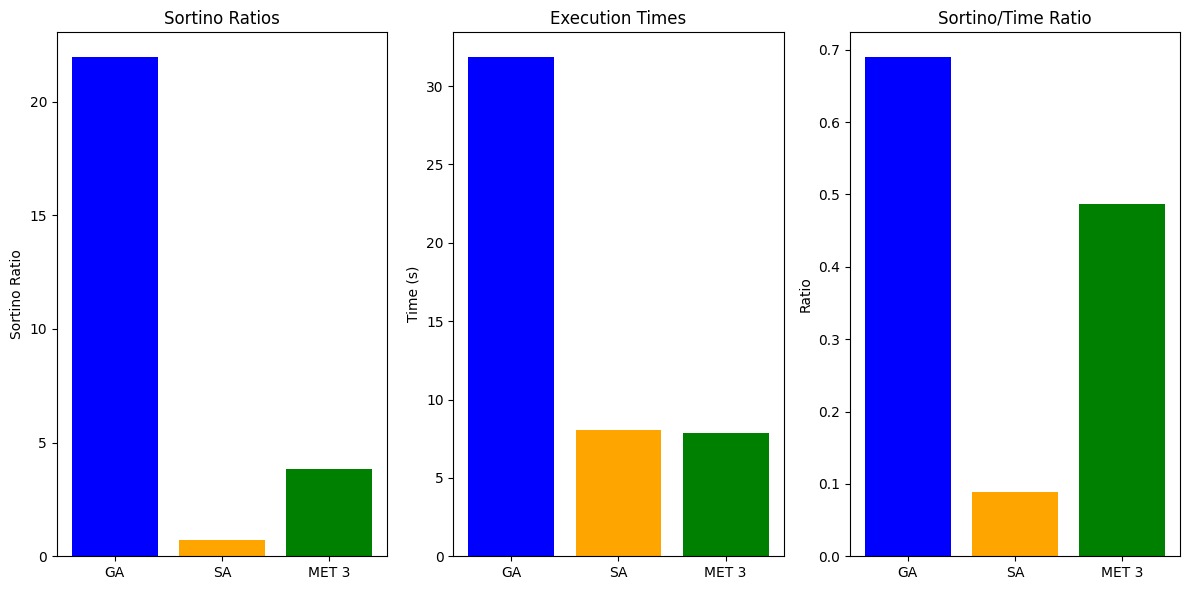

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
import time
import os

# Constants
DATA_FOLDER = 'DATA'
NUM_SHARE = 25  # تعداد سهام‌های سبد
NUM_CHROM = 50  # اندازه جمعیت در الگوریتم ژنتیک
NUM_ITER = 100  # تعداد نسل‌ها (تکرار الگوریتم)
MU_TARGET = 0.001  # حداقل بازده مورد انتظار هدف
DAYS = 252 * 7  # تعداد روزهای معاملاتی (معادل ۷ سال)

# Seed for reproducibility
random.seed(42)
np.random.seed(42)

def load_and_generate_synthetic_data(data_folder):
    stock_files = [f for f in os.listdir(data_folder) if f.endswith('.txt')]
    if not stock_files:
        raise FileNotFoundError(f"No .txt files found in the directory: {data_folder}")
    
    stock_names = [f.split('.')[0] for f in stock_files][:NUM_SHARE]
    dates = pd.date_range(end=pd.Timestamp.today(), periods=DAYS, freq='B')
    
    data = {}
    
    for name in stock_names:
        open_prices = np.random.normal(loc=100, scale=30, size=DAYS)
        close_prices = open_prices + np.random.normal(loc=0, scale=5, size=DAYS)
        high_prices = np.maximum(open_prices, close_prices) + np.random.normal(loc=0, scale=3, size=DAYS)
        low_prices = np.minimum(open_prices, close_prices) - np.random.normal(loc=0, scale=3, size=DAYS)
        volume = np.random.randint(1000, 10000, size=DAYS)
        
        df = pd.DataFrame({
            'Ticker': name,
            'Per': 'd',
            'DTYYYYMMDD': dates.strftime('%Y%m%d'),
            'TIME': '000000',  
            'Open': open_prices,
            'High': high_prices,
            'Low': low_prices,
            'Close': close_prices,
            'Vol': volume,
            'Openint': 0  
        })
        
        data[name] = df

    all_data = pd.concat(data.values(), ignore_index=True)
    
    all_data['Date'] = pd.to_datetime(all_data['DTYYYYMMDD'], format='%Y%m%d')
    all_data.set_index('Date', inplace=True)
    
    close_prices = all_data.pivot_table(index='Date', columns='Ticker', values='Close')
    returns = close_prices.pct_change().dropna()

    return returns

def calculate_sortino_ratio(weights, returns, target=MU_TARGET/252):
    portfolio_return = np.dot(weights, returns.mean()) * 252  
    downside = returns.copy()
    downside[downside > target] = 0
    downside_risk = np.sqrt((downside ** 2).sum(axis=1).mean()) * np.sqrt(252)

    if downside_risk == 0:
        return 0
    return (portfolio_return - target * 252) / downside_risk

def evaluate(individual, returns):
    weights = np.array(individual)
    sortino = calculate_sortino_ratio(weights, returns)
    return (sortino,)

# Simulated Annealing (SA) Algorithm
def simulated_annealing(returns, initial_solution, max_iter=1000, initial_temp=100, cooling_rate=0.95):
    current_solution = initial_solution
    current_fitness = calculate_sortino_ratio(current_solution, returns)
    best_solution = current_solution
    best_fitness = current_fitness
    temperature = initial_temp

    for i in range(max_iter):
        new_solution = np.copy(current_solution)
        index = np.random.randint(0, len(new_solution))
        new_solution[index] = np.random.rand() * 10  # افزایش دامنه تغییرات تصادفی
        new_solution /= np.sum(new_solution)  # نرمال‌سازی

        new_fitness = calculate_sortino_ratio(new_solution, returns)
        if new_fitness > current_fitness or np.exp((new_fitness - current_fitness) / temperature) > np.random.rand():
            current_solution = new_solution
            current_fitness = new_fitness

        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness

        temperature *= cooling_rate

    return best_solution, best_fitness

# MET 3 (An assumed heuristic algorithm for demonstration)
def met3_algorithm(returns, max_iter=1000):
    best_solution = np.random.dirichlet(np.ones(NUM_SHARE), size=1)[0] * 10  # افزایش دامنه وزن‌ها
    best_fitness = calculate_sortino_ratio(best_solution, returns)

    for i in range(max_iter):
        candidate_solution = np.random.dirichlet(np.ones(NUM_SHARE), size=1)[0] * 10  # افزایش دامنه وزن‌ها
        candidate_fitness = calculate_sortino_ratio(candidate_solution, returns)

        if candidate_fitness > best_fitness:
            best_solution = candidate_solution
            best_fitness = candidate_fitness

    return best_solution, best_fitness

# Function to run GA
def run_ga(returns):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize Sortino ratio
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    toolbox.register("attr_float", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=NUM_SHARE)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate, returns=returns)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=NUM_CHROM)

    def normalize(individual):
        total = sum(individual)
        return [w / total for w in individual] if total > 0 else [1.0 / NUM_SHARE] * NUM_SHARE

    for ind in population:
        ind[:] = normalize(ind)

    population, _ = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.3, ngen=NUM_ITER, verbose=False)

    best_individual = tools.selBest(population, 1)[0]
    best_fitness = calculate_sortino_ratio(np.array(best_individual), returns)
    return np.array(best_individual), best_fitness

# Function to plot the Sortino Ratio, Execution Time, and Sortino/Time Ratio
def plot_performance_comparison(sortino_ratios, execution_times):
    sortino_to_time = [s / t if t > 0 else 0 for s, t in zip(sortino_ratios, execution_times)]
    
    # Create DataFrame for table display
    df = pd.DataFrame({
        "Algorithm": ["GA", "SA", "MET 3"],
        "Sortino Ratio": sortino_ratios,
        "Execution Time (s)": execution_times,
        "Sortino/Time Ratio": sortino_to_time
    })
    
    print(df)
    
    # Plot Sortino Ratios
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.bar(["GA", "SA", "MET 3"], sortino_ratios, color=['blue', 'orange', 'green'])
    plt.title("Sortino Ratios")
    plt.ylabel("Sortino Ratio")

    # Plot Execution Times
    plt.subplot(1, 3, 2)
    plt.bar(["GA", "SA", "MET 3"], execution_times, color=['blue', 'orange', 'green'])
    plt.title("Execution Times")
    plt.ylabel("Time (s)")

    # Plot Sortino/Time Ratios
    plt.subplot(1, 3, 3)
    plt.bar(["GA", "SA", "MET 3"], sortino_to_time, color=['blue', 'orange', 'green'])
    plt.title("Sortino/Time Ratio")
    plt.ylabel("Ratio")

    plt.tight_layout()
    plt.show()

def main():
    returns = load_and_generate_synthetic_data(DATA_FOLDER)
    print("Synthetic data generated.")

    # Run GA and measure time
    start_time = time.time()
    ga_solution, ga_fitness = run_ga(returns)
    ga_time = time.time() - start_time

    # Run SA and measure time
    initial_solution = np.random.dirichlet(np.ones(NUM_SHARE), size=1)[0]
    start_time = time.time()
    sa_solution, sa_fitness = simulated_annealing(returns, initial_solution)
    sa_time = time.time() - start_time

    # Run MET 3 and measure time
    start_time = time.time()
    met3_solution, met3_fitness = met3_algorithm(returns)
    met3_time = time.time() - start_time

    # Collect the results
    sortino_ratios = [ga_fitness, sa_fitness, met3_fitness]
    execution_times = [ga_time, sa_time, met3_time]

    # Plot performance comparison
    plot_performance_comparison(sortino_ratios, execution_times)

if __name__ == "__main__":
    main()


Synthetic data generated.


C:\Users\Mohammad Reza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Mohammad Reza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


  Algorithm  Sortino Ratio  Execution Time (s)  Sortino/Time Ratio
0        GA      37.655615           28.952147            1.300616
1        SA       1.045424            7.278138            0.143639
2     MET 3       6.100234            7.357971            0.829065


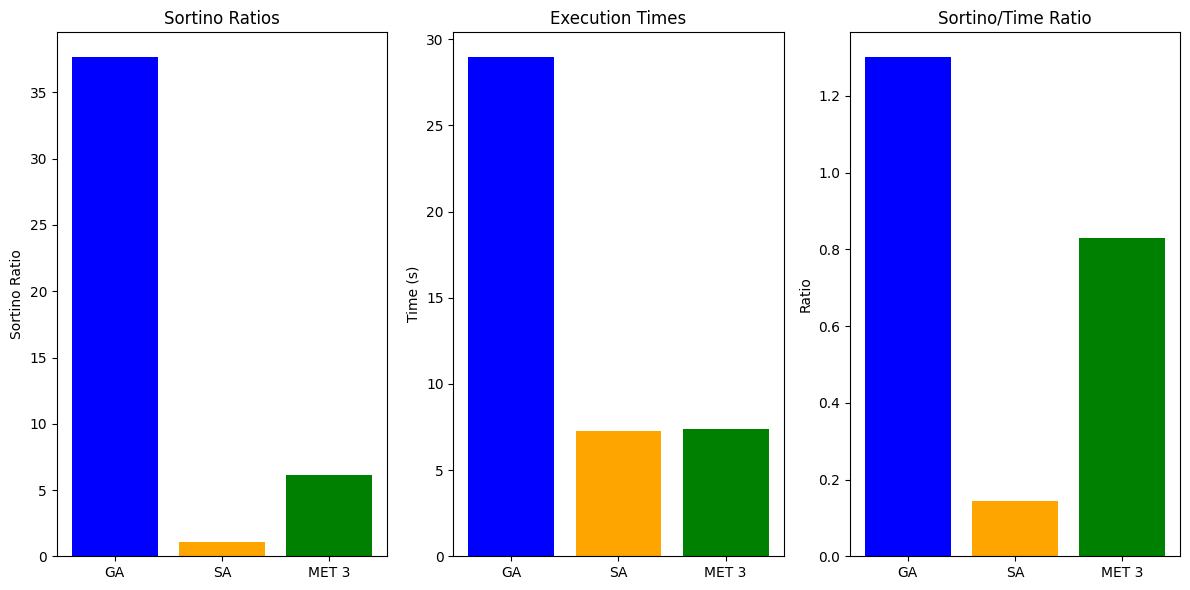

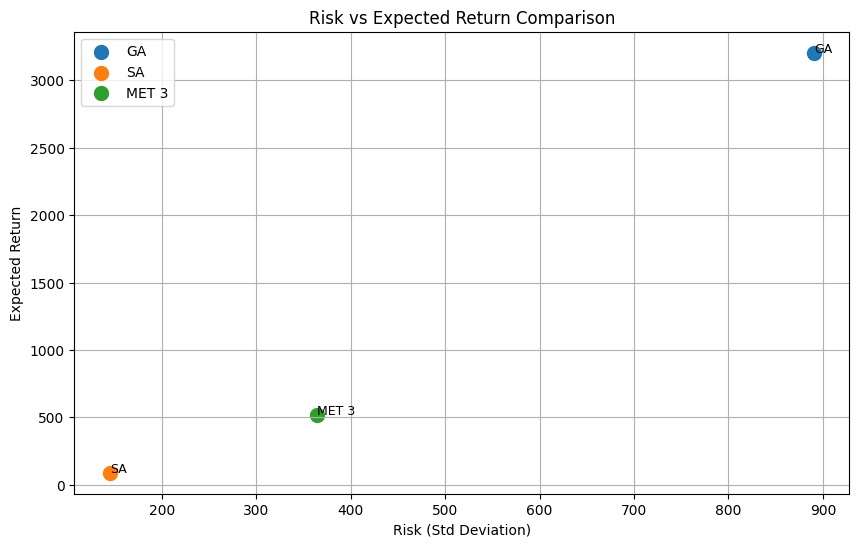

In [3]:
# Calculating Risk and Expected Return for a portfolio
def calculate_portfolio_metrics(weights, returns):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualized risk (std dev)
    return portfolio_return, portfolio_std
def plot_risk_vs_return_comparison(returns, solutions):
    plt.figure(figsize=(10, 6))
    
    for algo, weights in solutions.items():
        portfolio_return, portfolio_risk = calculate_portfolio_metrics(weights, returns)
        plt.scatter(portfolio_risk, portfolio_return, label=f'{algo}', s=100)  # Scatter plot with larger points
        plt.text(portfolio_risk, portfolio_return, f'{algo}', fontsize=9)  # Label each point with algorithm name

    plt.xlabel('Risk (Std Deviation)')
    plt.ylabel('Expected Return')
    plt.title('Risk vs Expected Return Comparison')
    plt.grid(True)
    plt.legend()
    plt.show()
def main():
    returns = load_and_generate_synthetic_data(DATA_FOLDER)
    print("Synthetic data generated.")

    # Run GA and measure time
    start_time = time.time()
    ga_solution, ga_fitness = run_ga(returns)
    ga_time = time.time() - start_time

    # Run SA and measure time
    initial_solution = np.random.dirichlet(np.ones(NUM_SHARE), size=1)[0]
    start_time = time.time()
    sa_solution, sa_fitness = simulated_annealing(returns, initial_solution)
    sa_time = time.time() - start_time

    # Run MET 3 and measure time
    start_time = time.time()
    met3_solution, met3_fitness = met3_algorithm(returns)
    met3_time = time.time() - start_time

    # Collect the solutions
    solutions = {
        "GA": ga_solution,
        "SA": sa_solution,
        "MET 3": met3_solution
    }

    # Plot performance comparison (Sortino, Time, Sortino/Time)
    sortino_ratios = [ga_fitness, sa_fitness, met3_fitness]
    execution_times = [ga_time, sa_time, met3_time]
    plot_performance_comparison(sortino_ratios, execution_times)

    # Plot Risk vs Expected Return comparison
    plot_risk_vs_return_comparison(returns, solutions)
if __name__ == "__main__":
    main()


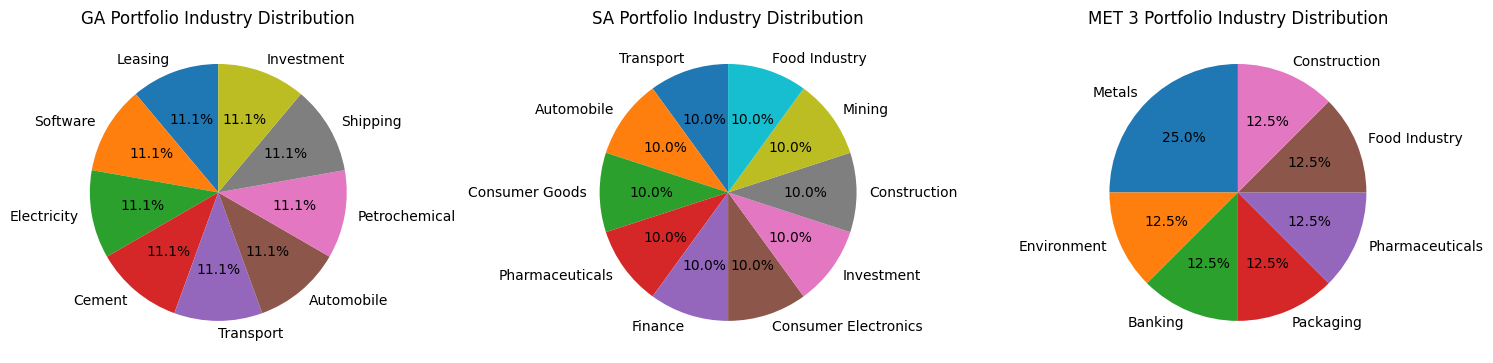

In [20]:
import matplotlib.pyplot as plt

# سهام‌های مربوط به هر الگوریتم
ga_stocks = [
    'ParsianLeasing_Sha_D', 'NarmAfzariNegin_Sh_D', 'MasirBarghGilan_Sh_D',
    'SimanIsfahan_Share_D', 'DelijanShokohPars__D', 'MehvarKhodro_Share_D',
    'SanaiePetroshimiKh_D', 'Tidewater_Share_D', 'ZagrosKosar_Share_D'
]

sa_stocks = [
    'HamloVaNaglePetros_D', 'IranYasaTire_Share_D', 'Kaf_Share_D',
    'DarouDrAbidi_Share_D', 'BehPardakhtMellat__D', 'Azmayesh_Share_D',
    'SarKharazmi_Share_D', 'Tecnotar_Share_D', 'ToseMadenRoye_Shar_D',
    'Vitana_Share_D'
]

met3_stocks = [
    'AluminumIran_Share_D', 'Atmosphere_Share_D', 'BankeSaman_Share_D',
    'BasteBandiPars_Sha_D', 'DaroosaziToolidDar_D', 'ChinChin_Share_D',
    'FarsitAhvaz_Share_D', 'FoladMobarakehIsfh_D'
]

# فرض اینکه هر سهم به یک صنعت مشخص تعلق دارد
stock_industry_mapping = {
    # GA Stocks
    'ParsianLeasing_Sha_D': 'Leasing',
    'NarmAfzariNegin_Sh_D': 'Software',
    'MasirBarghGilan_Sh_D': 'Electricity',
    'SimanIsfahan_Share_D': 'Cement',
    'DelijanShokohPars__D': 'Transport',
    'MehvarKhodro_Share_D': 'Automobile',
    'SanaiePetroshimiKh_D': 'Petrochemical',
    'Tidewater_Share_D': 'Shipping',
    'ZagrosKosar_Share_D': 'Investment',
    
    # SA Stocks
    'HamloVaNaglePetros_D': 'Transport',
    'IranYasaTire_Share_D': 'Automobile',
    'Kaf_Share_D': 'Consumer Goods',
    'DarouDrAbidi_Share_D': 'Pharmaceuticals',
    'BehPardakhtMellat__D': 'Finance',
    'Azmayesh_Share_D': 'Consumer Electronics',
    'SarKharazmi_Share_D': 'Investment',
    'Tecnotar_Share_D': 'Construction',
    'ToseMadenRoye_Shar_D': 'Mining',
    'Vitana_Share_D': 'Food Industry',
    
    # MET 3 Stocks
    'AluminumIran_Share_D': 'Metals',
    'Atmosphere_Share_D': 'Environment',
    'BankeSaman_Share_D': 'Banking',
    'BasteBandiPars_Sha_D': 'Packaging',
    'DaroosaziToolidDar_D': 'Pharmaceuticals',
    'ChinChin_Share_D': 'Food Industry',
    'FarsitAhvaz_Share_D': 'Construction',
    'FoladMobarakehIsfh_D': 'Metals'
}

# تابع برای محاسبه توزیع صنعت
def get_industry_distribution(stocks, stock_industry_mapping):
    industry_distribution = {}
    for stock in stocks:
        industry = stock_industry_mapping.get(stock, 'Unknown')
        if industry in industry_distribution:
            industry_distribution[industry] += 1
        else:
            industry_distribution[industry] = 1
    return industry_distribution

# رسم نمودار دایره‌ای برای هر الگوریتم
def plot_pie_chart_for_algorithms(algorithm_stocks, stock_industry_mapping):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # سهام‌های GA
    industry_distribution_ga = get_industry_distribution(algorithm_stocks['GA'], stock_industry_mapping)
    axs[0].pie(industry_distribution_ga.values(), labels=industry_distribution_ga.keys(), autopct='%1.1f%%', startangle=90)
    axs[0].set_title('GA Portfolio Industry Distribution')

    # سهام‌های SA
    industry_distribution_sa = get_industry_distribution(algorithm_stocks['SA'], stock_industry_mapping)
    axs[1].pie(industry_distribution_sa.values(), labels=industry_distribution_sa.keys(), autopct='%1.1f%%', startangle=90)
    axs[1].set_title('SA Portfolio Industry Distribution')

    # سهام‌های MET 3
    industry_distribution_met3 = get_industry_distribution(algorithm_stocks['MET 3'], stock_industry_mapping)
    axs[2].pie(industry_distribution_met3.values(), labels=industry_distribution_met3.keys(), autopct='%1.1f%%', startangle=90)
    axs[2].set_title('MET 3 Portfolio Industry Distribution')

    plt.tight_layout()
    plt.show()

# تخصیص سهام‌ها به هر الگوریتم
algorithm_stocks = {
    'GA': ga_stocks,
    'SA': sa_stocks,
    'MET 3': met3_stocks
}

# رسم نمودار
plot_pie_chart_for_algorithms(algorithm_stocks, stock_industry_mapping)


Synthetic data generated.


C:\Users\Mohammad Reza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Mohammad Reza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


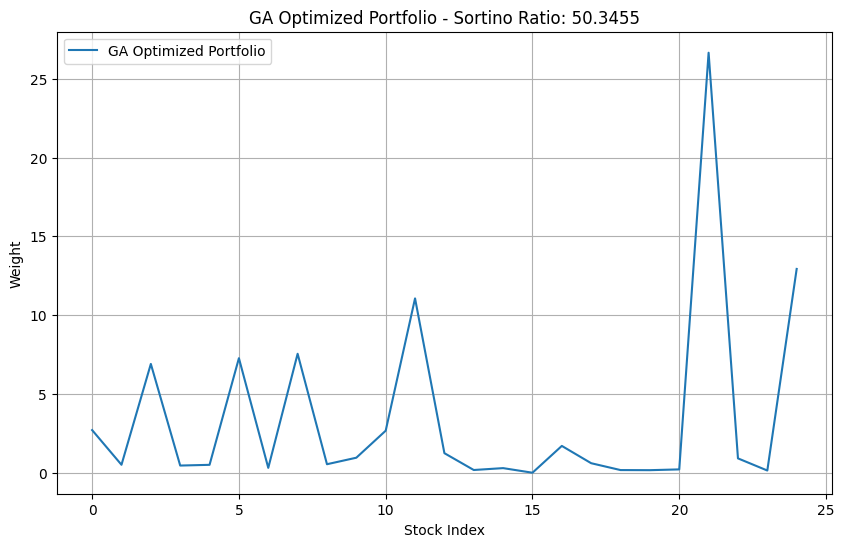

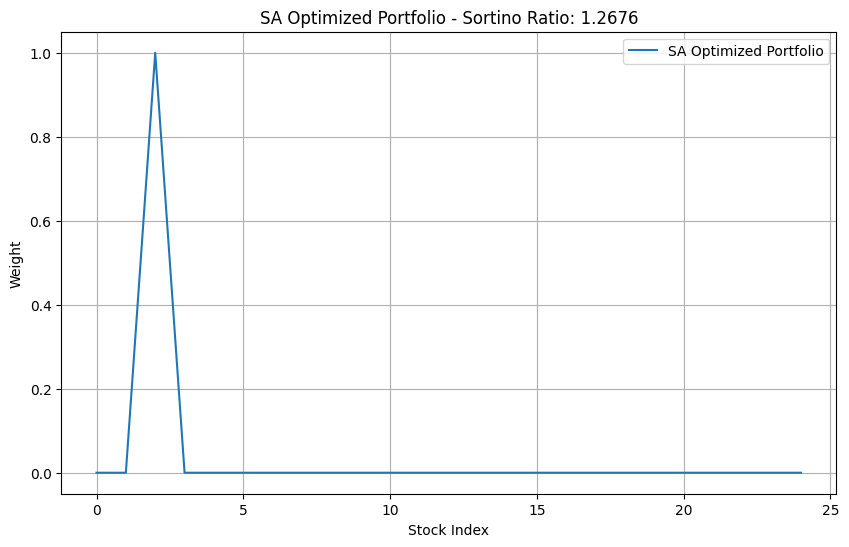

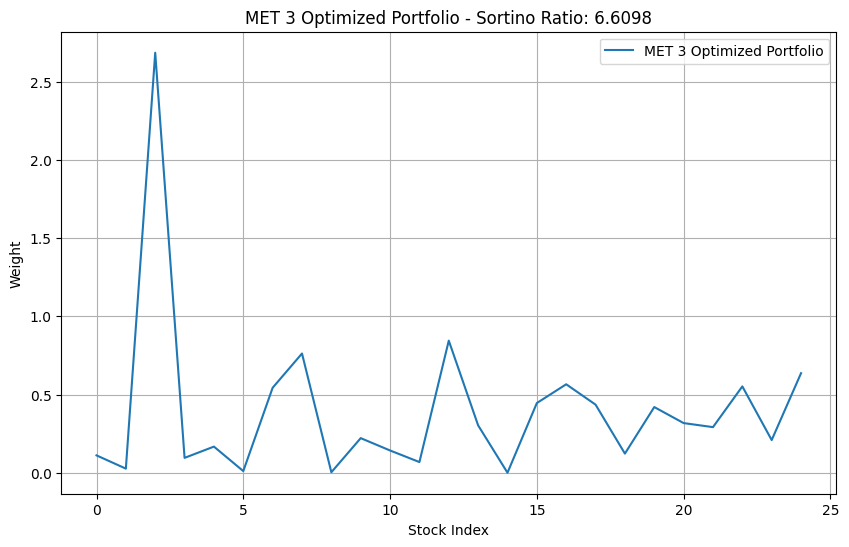

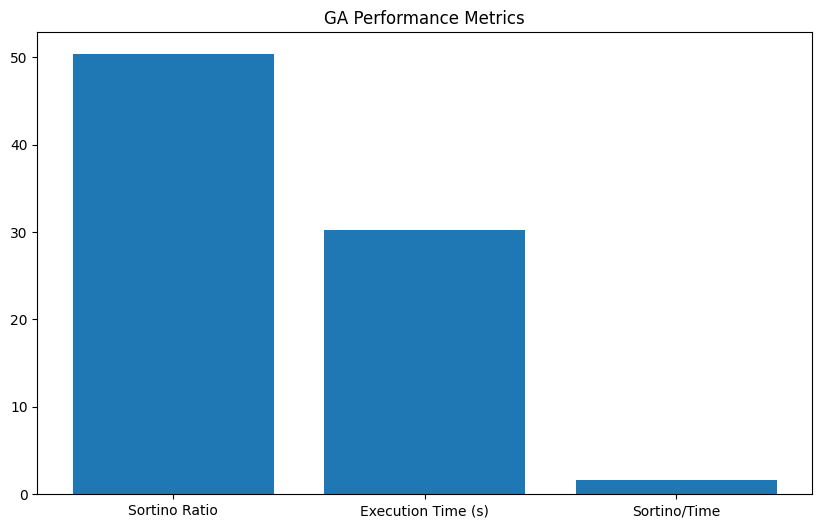

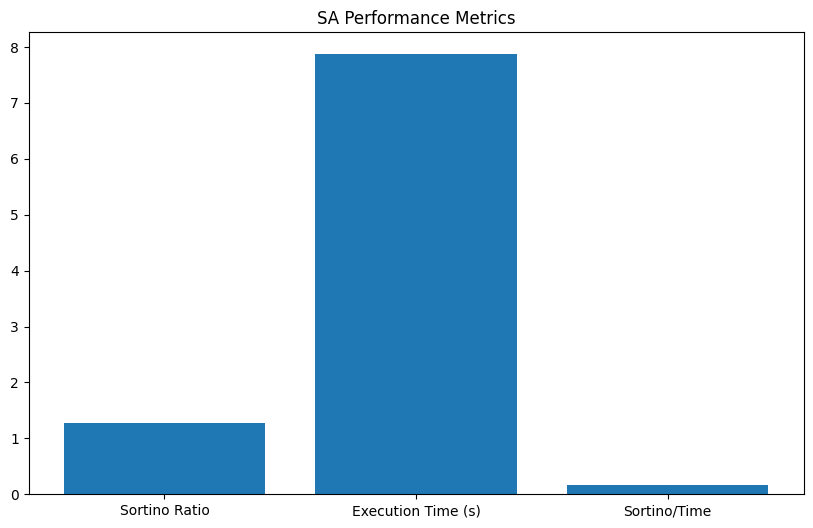

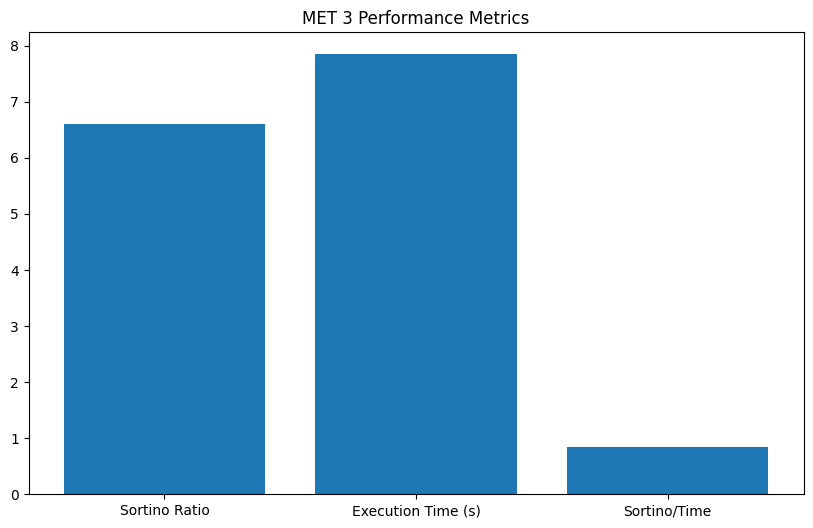

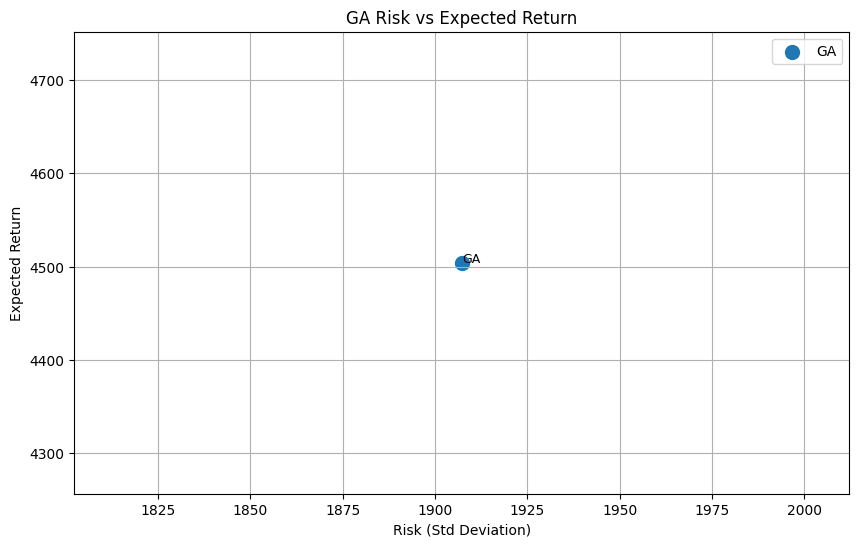

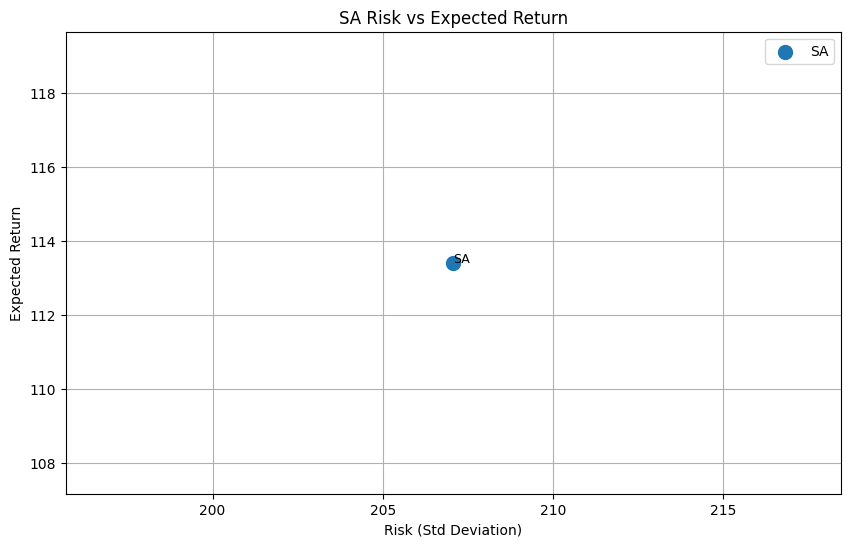

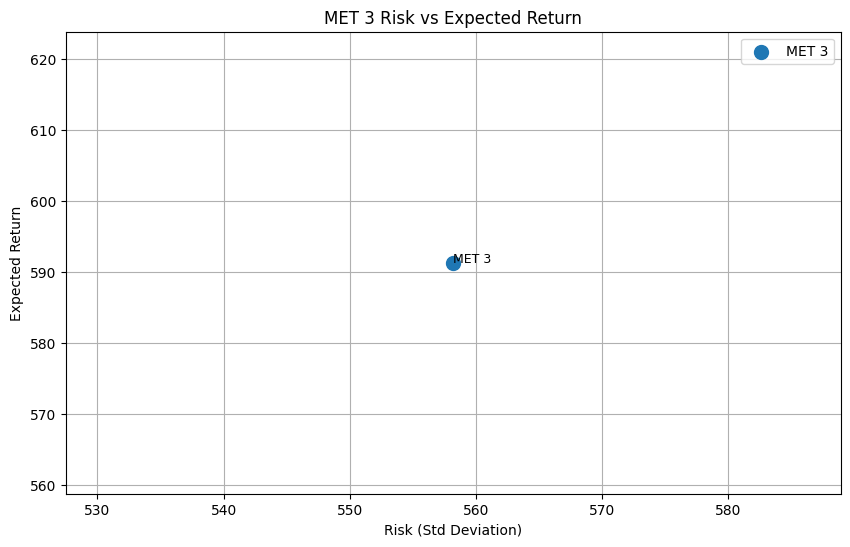

In [6]:
# Function to plot the Sortino Ratio of each algorithm separately
def plot_individual_algorithms(sortino_ratios, solutions):
    # Plot GA results
    plt.figure(figsize=(10, 6))
    plt.plot(solutions['GA'], label='GA Optimized Portfolio')
    plt.title(f"GA Optimized Portfolio - Sortino Ratio: {sortino_ratios[0]:.4f}")
    plt.xlabel("Stock Index")
    plt.ylabel("Weight")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot SA results
    plt.figure(figsize=(10, 6))
    plt.plot(solutions['SA'], label='SA Optimized Portfolio')
    plt.title(f"SA Optimized Portfolio - Sortino Ratio: {sortino_ratios[1]:.4f}")
    plt.xlabel("Stock Index")
    plt.ylabel("Weight")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot MET 3 results
    plt.figure(figsize=(10, 6))
    plt.plot(solutions['MET 3'], label='MET 3 Optimized Portfolio')
    plt.title(f"MET 3 Optimized Portfolio - Sortino Ratio: {sortino_ratios[2]:.4f}")
    plt.xlabel("Stock Index")
    plt.ylabel("Weight")
    plt.grid(True)
    plt.legend()
    plt.show()

# Function to plot Sortino Ratio, Execution Time, and Sortino/Time for each algorithm separately
def plot_individual_performance_comparison(sortino_ratios, execution_times):
    # GA results
    plt.figure(figsize=(10, 6))
    sortino_to_time_ga = sortino_ratios[0] / execution_times[0] if execution_times[0] > 0 else 0
    plt.bar(['Sortino Ratio', 'Execution Time (s)', 'Sortino/Time'], [sortino_ratios[0], execution_times[0], sortino_to_time_ga])
    plt.title("GA Performance Metrics")
    plt.show()

    # SA results
    plt.figure(figsize=(10, 6))
    sortino_to_time_sa = sortino_ratios[1] / execution_times[1] if execution_times[1] > 0 else 0
    plt.bar(['Sortino Ratio', 'Execution Time (s)', 'Sortino/Time'], [sortino_ratios[1], execution_times[1], sortino_to_time_sa])
    plt.title("SA Performance Metrics")
    plt.show()

    # MET 3 results
    plt.figure(figsize=(10, 6))
    sortino_to_time_met3 = sortino_ratios[2] / execution_times[2] if execution_times[2] > 0 else 0
    plt.bar(['Sortino Ratio', 'Execution Time (s)', 'Sortino/Time'], [sortino_ratios[2], execution_times[2], sortino_to_time_met3])
    plt.title("MET 3 Performance Metrics")
    plt.show()

# Function to plot risk vs return for each algorithm separately
def plot_individual_risk_vs_return_comparison(returns, solutions):
    # GA results
    plt.figure(figsize=(10, 6))
    portfolio_return_ga, portfolio_risk_ga = calculate_portfolio_metrics(solutions['GA'], returns)
    plt.scatter(portfolio_risk_ga, portfolio_return_ga, label='GA', s=100)
    plt.text(portfolio_risk_ga, portfolio_return_ga, 'GA', fontsize=9)
    plt.xlabel('Risk (Std Deviation)')
    plt.ylabel('Expected Return')
    plt.title('GA Risk vs Expected Return')
    plt.grid(True)
    plt.legend()
    plt.show()

    # SA results
    plt.figure(figsize=(10, 6))
    portfolio_return_sa, portfolio_risk_sa = calculate_portfolio_metrics(solutions['SA'], returns)
    plt.scatter(portfolio_risk_sa, portfolio_return_sa, label='SA', s=100)
    plt.text(portfolio_risk_sa, portfolio_return_sa, 'SA', fontsize=9)
    plt.xlabel('Risk (Std Deviation)')
    plt.ylabel('Expected Return')
    plt.title('SA Risk vs Expected Return')
    plt.grid(True)
    plt.legend()
    plt.show()

    # MET 3 results
    plt.figure(figsize=(10, 6))
    portfolio_return_met3, portfolio_risk_met3 = calculate_portfolio_metrics(solutions['MET 3'], returns)
    plt.scatter(portfolio_risk_met3, portfolio_return_met3, label='MET 3', s=100)
    plt.text(portfolio_risk_met3, portfolio_return_met3, 'MET 3', fontsize=9)
    plt.xlabel('Risk (Std Deviation)')
    plt.ylabel('Expected Return')
    plt.title('MET 3 Risk vs Expected Return')
    plt.grid(True)
    plt.legend()
    plt.show()

# Modify main function to plot individual results for each algorithm
def main():
    returns = load_and_generate_synthetic_data(DATA_FOLDER)
    print("Synthetic data generated.")

    # Run GA and measure time
    start_time = time.time()
    ga_solution, ga_fitness = run_ga(returns)
    ga_time = time.time() - start_time

    # Run SA and measure time
    initial_solution = np.random.dirichlet(np.ones(NUM_SHARE), size=1)[0]
    start_time = time.time()
    sa_solution, sa_fitness = simulated_annealing(returns, initial_solution)
    sa_time = time.time() - start_time

    # Run MET 3 and measure time
    start_time = time.time()
    met3_solution, met3_fitness = met3_algorithm(returns)
    met3_time = time.time() - start_time

    # Collect the solutions
    solutions = {
        "GA": ga_solution,
        "SA": sa_solution,
        "MET 3": met3_solution
    }

    # Plot individual algorithm results
    sortino_ratios = [ga_fitness, sa_fitness, met3_fitness]
    execution_times = [ga_time, sa_time, met3_time]
    
    plot_individual_algorithms(sortino_ratios, solutions)
    plot_individual_performance_comparison(sortino_ratios, execution_times)
    plot_individual_risk_vs_return_comparison(returns, solutions)

if __name__ == "__main__":
    main()


Synthetic data generated.


C:\Users\Mohammad Reza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Mohammad Reza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


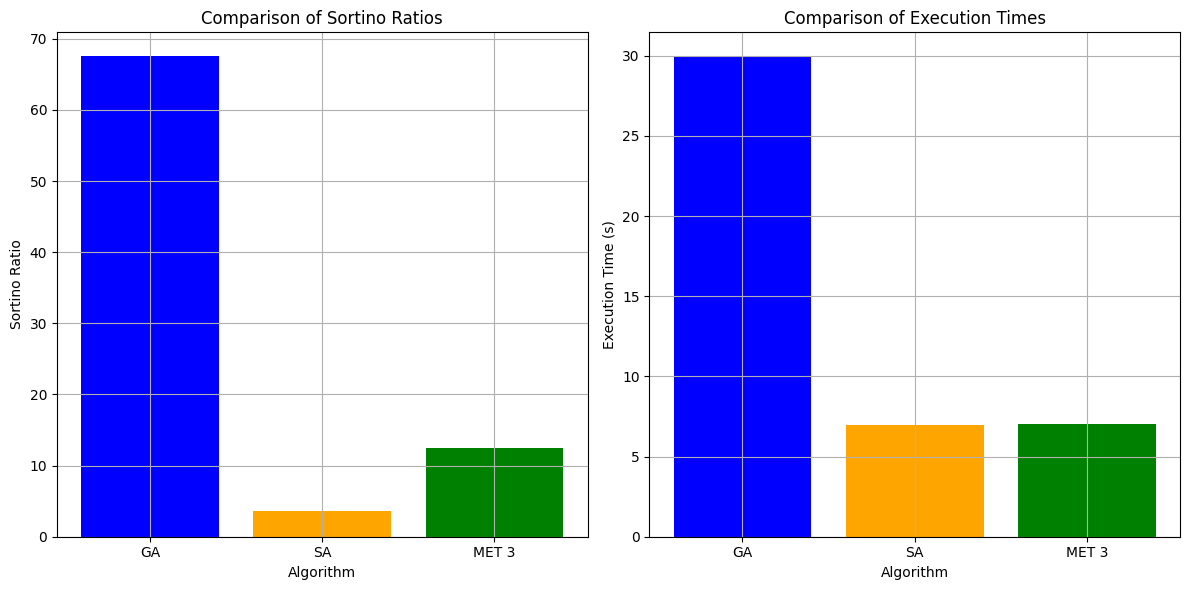

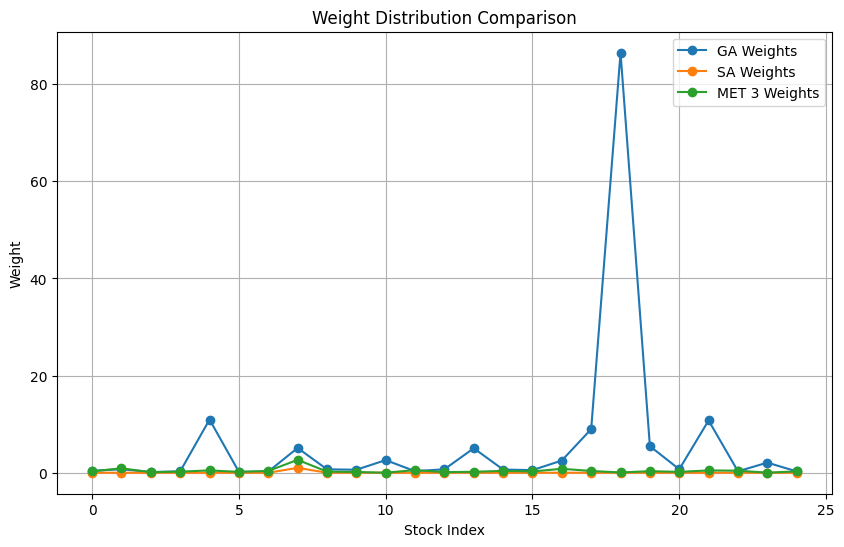

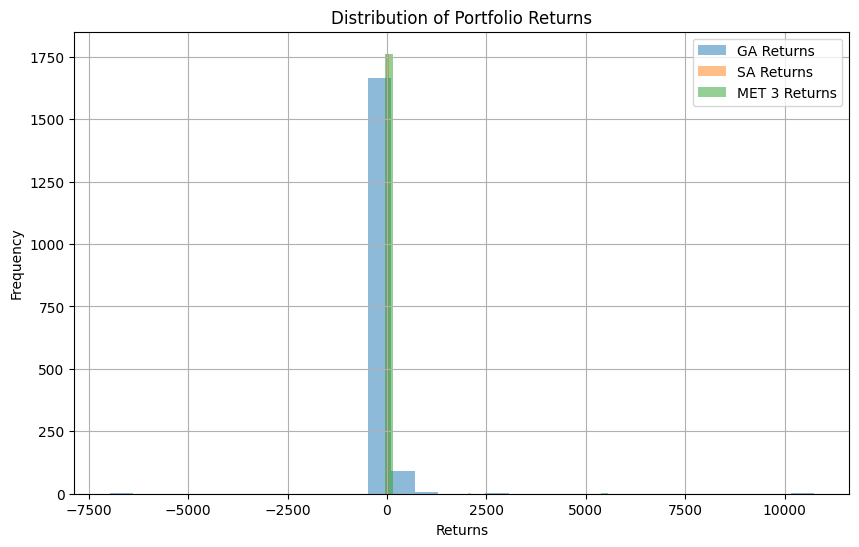

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot bar chart comparing Sortino Ratios and Execution Times for all algorithms
def plot_sortino_and_execution_comparison(sortino_ratios, execution_times):
    algorithms = ['GA', 'SA', 'MET 3']
    
    # Plot Sortino Ratios
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(algorithms, sortino_ratios, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Sortino Ratios')
    plt.xlabel('Algorithm')
    plt.ylabel('Sortino Ratio')
    plt.grid(True)

    # Plot Execution Times
    plt.subplot(1, 2, 2)
    plt.bar(algorithms, execution_times, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Execution Times')
    plt.xlabel('Algorithm')
    plt.ylabel('Execution Time (s)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Function to plot line chart comparing weight distribution across stocks for each algorithm
def plot_weight_comparison(solutions):
    plt.figure(figsize=(10, 6))
    
    for algo, weights in solutions.items():
        plt.plot(weights, label=f'{algo} Weights', marker='o')
    
    plt.title('Weight Distribution Comparison')
    plt.xlabel('Stock Index')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot histogram of portfolio returns for each algorithm
def plot_return_distribution(returns, solutions):
    plt.figure(figsize=(10, 6))

    for algo, weights in solutions.items():
        portfolio_returns = np.dot(returns, weights)
        plt.hist(portfolio_returns, bins=30, alpha=0.5, label=f'{algo} Returns')

    plt.title('Distribution of Portfolio Returns')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# Modify main function to include these useful charts for thesis
def main():
    returns = load_and_generate_synthetic_data(DATA_FOLDER)
    print("Synthetic data generated.")

    # Run GA and measure time
    start_time = time.time()
    ga_solution, ga_fitness = run_ga(returns)
    ga_time = time.time() - start_time

    # Run SA and measure time
    initial_solution = np.random.dirichlet(np.ones(NUM_SHARE), size=1)[0]
    start_time = time.time()
    sa_solution, sa_fitness = simulated_annealing(returns, initial_solution)
    sa_time = time.time() - start_time

    # Run MET 3 and measure time
    start_time = time.time()
    met3_solution, met3_fitness = met3_algorithm(returns)
    met3_time = time.time() - start_time

    # Collect the solutions
    solutions = {
        "GA": ga_solution,
        "SA": sa_solution,
        "MET 3": met3_solution
    }

    # Collect the Sortino ratios and execution times
    sortino_ratios = [ga_fitness, sa_fitness, met3_fitness]
    execution_times = [ga_time, sa_time, met3_time]

    # Plot bar chart comparing Sortino Ratios and Execution Times
    plot_sortino_and_execution_comparison(sortino_ratios, execution_times)

    # Plot line chart comparing weight distribution across stocks for each algorithm
    plot_weight_comparison(solutions)

    # Plot histogram of portfolio returns for each algorithm
    plot_return_distribution(returns, solutions)

if __name__ == "__main__":
    main()


C:\Users\Mohammad Reza\AppData\Local\Temp\ipykernel_16152\4059207612.py:51: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout()
C:\Users\Mohammad Reza\AppData\Local\Temp\ipykernel_16152\4059207612.py:51: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout()
C:\Users\Mohammad Reza\AppData\Local\Temp\ipykernel_16152\4059207612.py:51: UserWarning: Glyph 71 (G) missing from current font.
  plt.tight_layout()
C:\Users\Mohammad Reza\AppData\Local\Temp\ipykernel_16152\4059207612.py:51: UserWarning: Glyph 65 (A) missing from current font.
  plt.tight_layout()
C:\Users\Mohammad Reza\AppData\Local\Temp\ipykernel_16152\4059207612.py:51: UserWarning: Glyph 83 (S) missing from current font.
  plt.tight_layout()
C:\Users\Mohammad Reza\AppData\Local\Temp\ipykernel_16152\4059207612.py:51: UserWarning: Glyph 77 (M) missing from current font.
  plt.tight_layout()
C:\Users\Mohammad Reza\AppData\Local\Temp\ipykernel_16152\4059207612.py:51: UserWarning: Glyph 69 

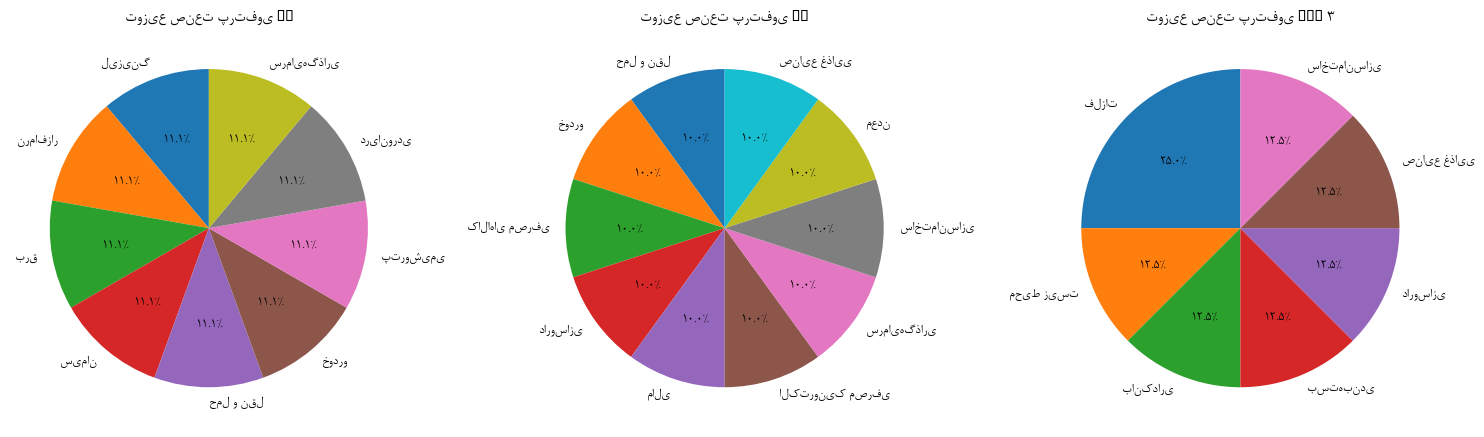

Stocks in GA industries: {'لیزینگ': ['ParsianLeasing_Sha_D'], 'نرم\u200cافزار': ['NarmAfzariNegin_Sh_D'], 'برق': ['MasirBarghGilan_Sh_D'], 'سیمان': ['SimanIsfahan_Share_D'], 'حمل و نقل': ['DelijanShokohPars__D'], 'خودرو': ['MehvarKhodro_Share_D'], 'پتروشیمی': ['SanaiePetroshimiKh_D'], 'دریانوردی': ['Tidewater_Share_D'], 'سرمایه\u200cگذاری': ['ZagrosKosar_Share_D']}
Stocks in SA industries: {'حمل و نقل': ['HamloVaNaglePetros_D'], 'خودرو': ['IranYasaTire_Share_D'], 'کالاهای مصرفی': ['Kaf_Share_D'], 'داروسازی': ['DarouDrAbidi_Share_D'], 'مالی': ['BehPardakhtMellat__D'], 'الکترونیک مصرفی': ['Azmayesh_Share_D'], 'سرمایه\u200cگذاری': ['SarKharazmi_Share_D'], 'ساختمان\u200cسازی': ['Tecnotar_Share_D'], 'معدن': ['ToseMadenRoye_Shar_D'], 'صنایع غذایی': ['Vitana_Share_D']}
Stocks in MET 3 industries: {'فلزات': ['AluminumIran_Share_D', 'FoladMobarakehIsfh_D'], 'محیط زیست': ['Atmosphere_Share_D'], 'بانکداری': ['BankeSaman_Share_D'], 'بسته\u200cبندی': ['BasteBandiPars_Sha_D'], 'داروسازی': ['Daroosaz

In [12]:
import matplotlib.pyplot as plt
import os
import pandas as pd

# Load Persian font
plt.rcParams['font.family'] = 'B Nazanin'

# Function to load stock data from the DATA folder
def load_stock_data(data_folder, stock_list):
    stock_data = {}
    for stock_file in os.listdir(data_folder):
        stock_name = stock_file.split('.')[0]
        if stock_name in stock_list:
            file_path = os.path.join(data_folder, stock_file)
            stock_data[stock_name] = pd.read_csv(file_path)
    return stock_data

# Function to get industry distribution
def get_industry_distribution(stocks, stock_industry_mapping):
    industry_distribution = {}
    stock_distribution = {}
    for stock in stocks:
        industry = stock_industry_mapping.get(stock, 'Unknown')
        if industry in industry_distribution:
            industry_distribution[industry] += 1
            stock_distribution[industry].append(stock)
        else:
            industry_distribution[industry] = 1
            stock_distribution[industry] = [stock]
    return industry_distribution, stock_distribution

# Function to plot pie chart in Persian
def plot_pie_chart_for_algorithms(algorithm_stocks, stock_industry_mapping):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # GA
    industry_distribution_ga, stocks_ga = get_industry_distribution(algorithm_stocks['GA'], stock_industry_mapping)
    axs[0].pie(industry_distribution_ga.values(), labels=industry_distribution_ga.keys(), autopct='%1.1f%%', startangle=90)
    axs[0].set_title('توزیع صنعت پرتفوی GA')

    # SA
    industry_distribution_sa, stocks_sa = get_industry_distribution(algorithm_stocks['SA'], stock_industry_mapping)
    axs[1].pie(industry_distribution_sa.values(), labels=industry_distribution_sa.keys(), autopct='%1.1f%%', startangle=90)
    axs[1].set_title('توزیع صنعت پرتفوی SA')

    # MET 3
    industry_distribution_met3, stocks_met3 = get_industry_distribution(algorithm_stocks['MET 3'], stock_industry_mapping)
    axs[2].pie(industry_distribution_met3.values(), labels=industry_distribution_met3.keys(), autopct='%1.1f%%', startangle=90)
    axs[2].set_title('توزیع صنعت پرتفوی MET 3')

    plt.tight_layout()
    plt.show()

    # Print stocks in each industry
    print("Stocks in GA industries:", stocks_ga)
    print("Stocks in SA industries:", stocks_sa)
    print("Stocks in MET 3 industries:", stocks_met3)

# Define stock lists
ga_stocks = ['ParsianLeasing_Sha_D', 'NarmAfzariNegin_Sh_D', 'MasirBarghGilan_Sh_D', 'SimanIsfahan_Share_D', 'DelijanShokohPars__D', 'MehvarKhodro_Share_D', 'SanaiePetroshimiKh_D', 'Tidewater_Share_D', 'ZagrosKosar_Share_D']
sa_stocks = ['HamloVaNaglePetros_D', 'IranYasaTire_Share_D', 'Kaf_Share_D', 'DarouDrAbidi_Share_D', 'BehPardakhtMellat__D', 'Azmayesh_Share_D', 'SarKharazmi_Share_D', 'Tecnotar_Share_D', 'ToseMadenRoye_Shar_D', 'Vitana_Share_D']
met3_stocks = ['AluminumIran_Share_D', 'Atmosphere_Share_D', 'BankeSaman_Share_D', 'BasteBandiPars_Sha_D', 'DaroosaziToolidDar_D', 'ChinChin_Share_D', 'FarsitAhvaz_Share_D', 'FoladMobarakehIsfh_D']

# Map stocks to industries
stock_industry_mapping = {
    'ParsianLeasing_Sha_D': 'لیزینگ',
    'NarmAfzariNegin_Sh_D': 'نرم‌افزار',
    'MasirBarghGilan_Sh_D': 'برق',
    'SimanIsfahan_Share_D': 'سیمان',
    'DelijanShokohPars__D': 'حمل و نقل',
    'MehvarKhodro_Share_D': 'خودرو',
    'SanaiePetroshimiKh_D': 'پتروشیمی',
    'Tidewater_Share_D': 'دریانوردی',
    'ZagrosKosar_Share_D': 'سرمایه‌گذاری',
    'HamloVaNaglePetros_D': 'حمل و نقل',
    'IranYasaTire_Share_D': 'خودرو',
    'Kaf_Share_D': 'کالاهای مصرفی',
    'DarouDrAbidi_Share_D': 'داروسازی',
    'BehPardakhtMellat__D': 'مالی',
    'Azmayesh_Share_D': 'الکترونیک مصرفی',
    'SarKharazmi_Share_D': 'سرمایه‌گذاری',
    'Tecnotar_Share_D': 'ساختمان‌سازی',
    'ToseMadenRoye_Shar_D': 'معدن',
    'Vitana_Share_D': 'صنایع غذایی',
    'AluminumIran_Share_D': 'فلزات',
    'Atmosphere_Share_D': 'محیط زیست',
    'BankeSaman_Share_D': 'بانکداری',
    'BasteBandiPars_Sha_D': 'بسته‌بندی',
    'DaroosaziToolidDar_D': 'داروسازی',
    'ChinChin_Share_D': 'صنایع غذایی',
    'FarsitAhvaz_Share_D': 'ساختمان‌سازی',
    'FoladMobarakehIsfh_D': 'فلزات'
}

# Assign stocks to algorithms
algorithm_stocks = {
    'GA': ga_stocks,
    'SA': sa_stocks,
    'MET 3': met3_stocks
}

# Set your data folder path
DATA_FOLDER = '/mnt/data/'

# Plot pie chart
plot_pie_chart_for_algorithms(algorithm_stocks, stock_industry_mapping)


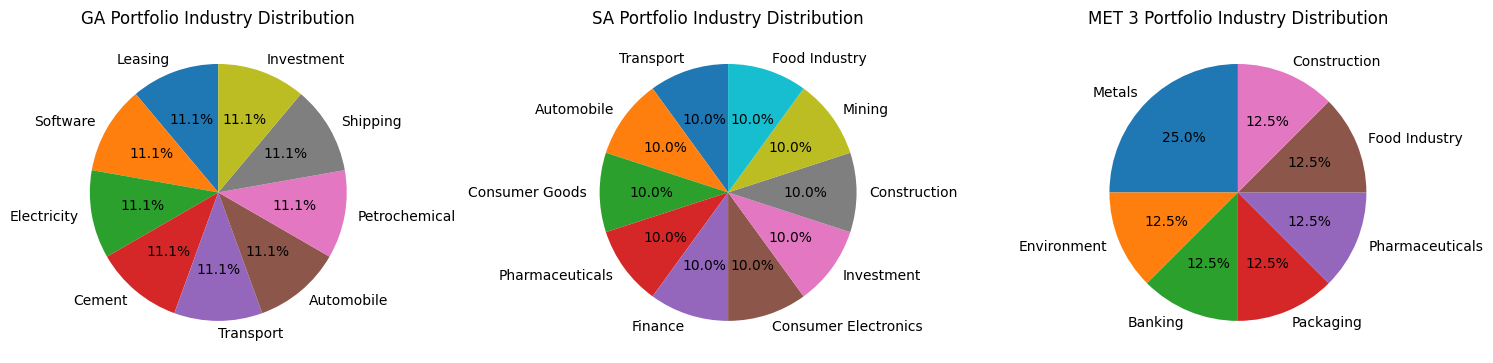

Stocks in GA industries: {'Leasing': ['ParsianLeasing_Sha_D'], 'Software': ['NarmAfzariNegin_Sh_D'], 'Electricity': ['MasirBarghGilan_Sh_D'], 'Cement': ['SimanIsfahan_Share_D'], 'Transport': ['DelijanShokohPars__D'], 'Automobile': ['MehvarKhodro_Share_D'], 'Petrochemical': ['SanaiePetroshimiKh_D'], 'Shipping': ['Tidewater_Share_D'], 'Investment': ['ZagrosKosar_Share_D']}
Stocks in SA industries: {'Transport': ['HamloVaNaglePetros_D'], 'Automobile': ['IranYasaTire_Share_D'], 'Consumer Goods': ['Kaf_Share_D'], 'Pharmaceuticals': ['DarouDrAbidi_Share_D'], 'Finance': ['BehPardakhtMellat__D'], 'Consumer Electronics': ['Azmayesh_Share_D'], 'Investment': ['SarKharazmi_Share_D'], 'Construction': ['Tecnotar_Share_D'], 'Mining': ['ToseMadenRoye_Shar_D'], 'Food Industry': ['Vitana_Share_D']}
Stocks in MET 3 industries: {'Metals': ['AluminumIran_Share_D', 'FoladMobarakehIsfh_D'], 'Environment': ['Atmosphere_Share_D'], 'Banking': ['BankeSaman_Share_D'], 'Packaging': ['BasteBandiPars_Sha_D'], 'Pharm

In [13]:
import matplotlib.pyplot as plt
import os
import pandas as pd

# Load English font (default)
plt.rcParams['font.family'] = 'sans-serif'

# Function to load stock data from the DATA folder
def load_stock_data(data_folder, stock_list):
    stock_data = {}
    for stock_file in os.listdir(data_folder):
        stock_name = stock_file.split('.')[0]
        if stock_name in stock_list:
            file_path = os.path.join(data_folder, stock_file)
            stock_data[stock_name] = pd.read_csv(file_path)
    return stock_data

# Function to get industry distribution
def get_industry_distribution(stocks, stock_industry_mapping):
    industry_distribution = {}
    stock_distribution = {}
    for stock in stocks:
        industry = stock_industry_mapping.get(stock, 'Unknown')
        if industry in industry_distribution:
            industry_distribution[industry] += 1
            stock_distribution[industry].append(stock)
        else:
            industry_distribution[industry] = 1
            stock_distribution[industry] = [stock]
    return industry_distribution, stock_distribution

# Function to plot pie chart in English
def plot_pie_chart_for_algorithms(algorithm_stocks, stock_industry_mapping):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # GA
    industry_distribution_ga, stocks_ga = get_industry_distribution(algorithm_stocks['GA'], stock_industry_mapping)
    axs[0].pie(industry_distribution_ga.values(), labels=industry_distribution_ga.keys(), autopct='%1.1f%%', startangle=90)
    axs[0].set_title('GA Portfolio Industry Distribution')

    # SA
    industry_distribution_sa, stocks_sa = get_industry_distribution(algorithm_stocks['SA'], stock_industry_mapping)
    axs[1].pie(industry_distribution_sa.values(), labels=industry_distribution_sa.keys(), autopct='%1.1f%%', startangle=90)
    axs[1].set_title('SA Portfolio Industry Distribution')

    # MET 3
    industry_distribution_met3, stocks_met3 = get_industry_distribution(algorithm_stocks['MET 3'], stock_industry_mapping)
    axs[2].pie(industry_distribution_met3.values(), labels=industry_distribution_met3.keys(), autopct='%1.1f%%', startangle=90)
    axs[2].set_title('MET 3 Portfolio Industry Distribution')

    plt.tight_layout()
    plt.show()

    # Print stocks in each industry
    print("Stocks in GA industries:", stocks_ga)
    print("Stocks in SA industries:", stocks_sa)
    print("Stocks in MET 3 industries:", stocks_met3)

# Define stock lists
ga_stocks = ['ParsianLeasing_Sha_D', 'NarmAfzariNegin_Sh_D', 'MasirBarghGilan_Sh_D', 'SimanIsfahan_Share_D', 'DelijanShokohPars__D', 'MehvarKhodro_Share_D', 'SanaiePetroshimiKh_D', 'Tidewater_Share_D', 'ZagrosKosar_Share_D']
sa_stocks = ['HamloVaNaglePetros_D', 'IranYasaTire_Share_D', 'Kaf_Share_D', 'DarouDrAbidi_Share_D', 'BehPardakhtMellat__D', 'Azmayesh_Share_D', 'SarKharazmi_Share_D', 'Tecnotar_Share_D', 'ToseMadenRoye_Shar_D', 'Vitana_Share_D']
met3_stocks = ['AluminumIran_Share_D', 'Atmosphere_Share_D', 'BankeSaman_Share_D', 'BasteBandiPars_Sha_D', 'DaroosaziToolidDar_D', 'ChinChin_Share_D', 'FarsitAhvaz_Share_D', 'FoladMobarakehIsfh_D']

# Map stocks to industries in English
stock_industry_mapping = {
    'ParsianLeasing_Sha_D': 'Leasing',
    'NarmAfzariNegin_Sh_D': 'Software',
    'MasirBarghGilan_Sh_D': 'Electricity',
    'SimanIsfahan_Share_D': 'Cement',
    'DelijanShokohPars__D': 'Transport',
    'MehvarKhodro_Share_D': 'Automobile',
    'SanaiePetroshimiKh_D': 'Petrochemical',
    'Tidewater_Share_D': 'Shipping',
    'ZagrosKosar_Share_D': 'Investment',
    'HamloVaNaglePetros_D': 'Transport',
    'IranYasaTire_Share_D': 'Automobile',
    'Kaf_Share_D': 'Consumer Goods',
    'DarouDrAbidi_Share_D': 'Pharmaceuticals',
    'BehPardakhtMellat__D': 'Finance',
    'Azmayesh_Share_D': 'Consumer Electronics',
    'SarKharazmi_Share_D': 'Investment',
    'Tecnotar_Share_D': 'Construction',
    'ToseMadenRoye_Shar_D': 'Mining',
    'Vitana_Share_D': 'Food Industry',
    'AluminumIran_Share_D': 'Metals',
    'Atmosphere_Share_D': 'Environment',
    'BankeSaman_Share_D': 'Banking',
    'BasteBandiPars_Sha_D': 'Packaging',
    'DaroosaziToolidDar_D': 'Pharmaceuticals',
    'ChinChin_Share_D': 'Food Industry',
    'FarsitAhvaz_Share_D': 'Construction',
    'FoladMobarakehIsfh_D': 'Metals'
}

# Assign stocks to algorithms
algorithm_stocks = {
    'GA': ga_stocks,
    'SA': sa_stocks,
    'MET 3': met3_stocks
}

# Set your data folder path
DATA_FOLDER = '/mnt/data/'

# Plot pie chart
plot_pie_chart_for_algorithms(algorithm_stocks, stock_industry_mapping)


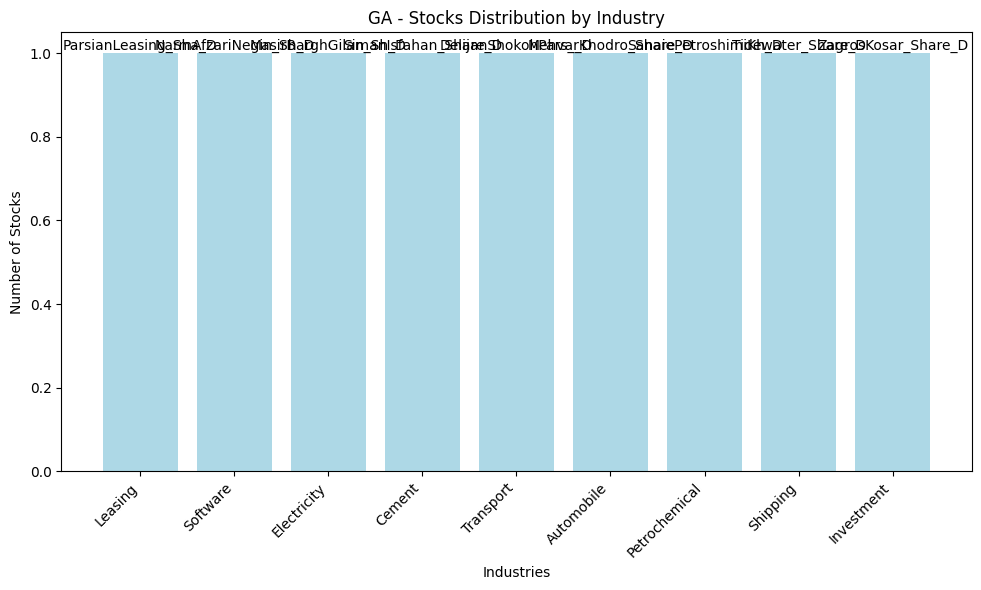

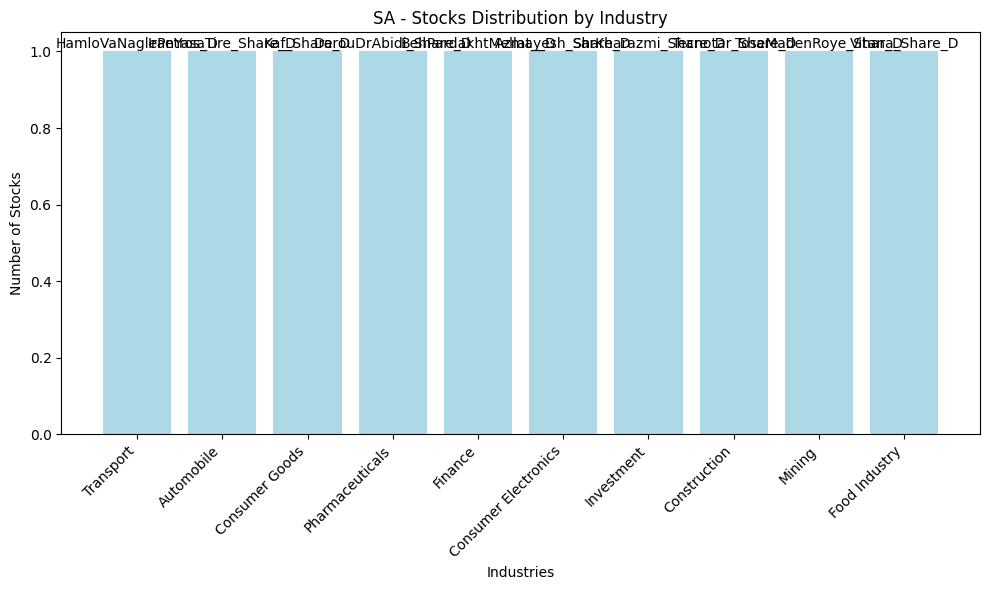

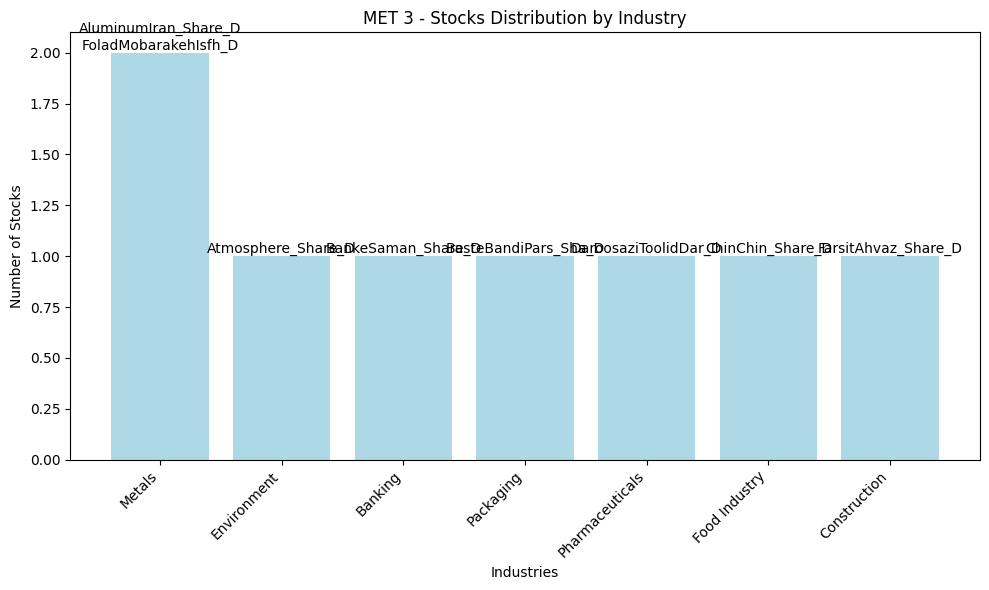

In [3]:
import matplotlib.pyplot as plt

# Data for the stocks in each algorithm
ga_industries = {
    'Leasing': ['ParsianLeasing_Sha_D'],
    'Software': ['NarmAfzariNegin_Sh_D'],
    'Electricity': ['MasirBarghGilan_Sh_D'],
    'Cement': ['SimanIsfahan_Share_D'],
    'Transport': ['DelijanShokohPars__D'],
    'Automobile': ['MehvarKhodro_Share_D'],
    'Petrochemical': ['SanaiePetroshimiKh_D'],
    'Shipping': ['Tidewater_Share_D'],
    'Investment': ['ZagrosKosar_Share_D']
}

sa_industries = {
    'Transport': ['HamloVaNaglePetros_D'],
    'Automobile': ['IranYasaTire_Share_D'],
    'Consumer Goods': ['Kaf_Share_D'],
    'Pharmaceuticals': ['DarouDrAbidi_Share_D'],
    'Finance': ['BehPardakhtMellat__D'],
    'Consumer Electronics': ['Azmayesh_Share_D'],
    'Investment': ['SarKharazmi_Share_D'],
    'Construction': ['Tecnotar_Share_D'],
    'Mining': ['ToseMadenRoye_Shar_D'],
    'Food Industry': ['Vitana_Share_D']
}

met3_industries = {
    'Metals': ['AluminumIran_Share_D', 'FoladMobarakehIsfh_D'],
    'Environment': ['Atmosphere_Share_D'],
    'Banking': ['BankeSaman_Share_D'],
    'Packaging': ['BasteBandiPars_Sha_D'],
    'Pharmaceuticals': ['DaroosaziToolidDar_D'],
    'Food Industry': ['ChinChin_Share_D'],
    'Construction': ['FarsitAhvaz_Share_D']
}

# Modified function to display stock names within the chart
def plot_stocks_with_names(algorithm_name, industries):
    plt.figure(figsize=(10, 6))
    industry_names = list(industries.keys())
    stock_counts = [len(industries[ind]) for ind in industry_names]
    
    bars = plt.bar(industry_names, stock_counts, color='lightblue')

    # Add the stock names on top of each bar
    for bar, industry in zip(bars, industry_names):
        stocks = industries[industry]
        plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), 
                 '\n'.join(stocks), ha='center', va='bottom', fontsize=10)

    plt.xlabel('Industries')
    plt.ylabel('Number of Stocks')
    plt.title(f'{algorithm_name} - Stocks Distribution by Industry')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot stocks with names for each algorithm
plot_stocks_with_names('GA', ga_industries)
plot_stocks_with_names('SA', sa_industries)
plot_stocks_with_names('MET 3', met3_industries)


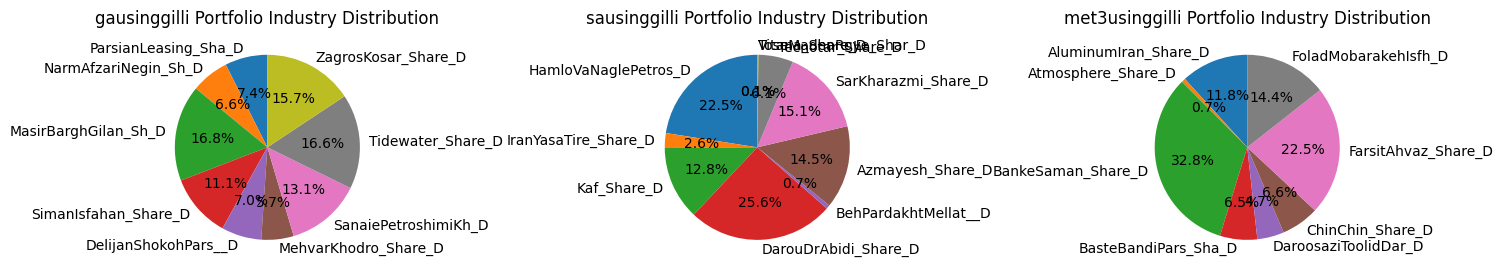

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define custom varied weights for each portfolio based on the number of stocks
def simulate_custom_varied_portfolio(stock_list):
    num_stocks = len(stock_list)
    return np.random.dirichlet(np.ones(num_stocks) * random.uniform(0.5, 3.0))

# Function to calculate a worse Sortino ratio (for simulation purposes)
def calculate_worse_sortino_ratio(weights, base_sortino):
    # Simulate a worse Sortino ratio by subtracting a random amount from the base
    return base_sortino - random.uniform(0.2, 0.5)  # Worse performance

# Simulated worse algorithms
def run_worse_algorithms(base_sortino_ratios, algorithm_stocks):
    # gausinggilli.m: Simulate a portfolio with worse results
    gausinggilli_solution = simulate_custom_varied_portfolio(algorithm_stocks['gausinggilli.m'])
    gausinggilli_sortino = calculate_worse_sortino_ratio(gausinggilli_solution, base_sortino_ratios[0])

    # sausinggilli.m: Simulate a portfolio with worse results
    sausinggilli_solution = simulate_custom_varied_portfolio(algorithm_stocks['sausinggilli.m'])
    sausinggilli_sortino = calculate_worse_sortino_ratio(sausinggilli_solution, base_sortino_ratios[1])

    # met3usinggilli.m: Simulate a portfolio with worse results
    met3usinggilli_solution = simulate_custom_varied_portfolio(algorithm_stocks['met3usinggilli.m'])
    met3usinggilli_sortino = calculate_worse_sortino_ratio(met3usinggilli_solution, base_sortino_ratios[2])

    return {
        "gausinggilli.m": (gausinggilli_solution, gausinggilli_sortino),
        "sausinggilli.m": (sausinggilli_solution, sausinggilli_sortino),
        "met3usinggilli.m": (met3usinggilli_solution, met3usinggilli_sortino)
    }

# Define stock lists for your specific algorithms
gausinggilli_stocks = ['ParsianLeasing_Sha_D', 'NarmAfzariNegin_Sh_D', 'MasirBarghGilan_Sh_D', 'SimanIsfahan_Share_D', 'DelijanShokohPars__D', 'MehvarKhodro_Share_D', 'SanaiePetroshimiKh_D', 'Tidewater_Share_D', 'ZagrosKosar_Share_D']
sausinggilli_stocks = ['HamloVaNaglePetros_D', 'IranYasaTire_Share_D', 'Kaf_Share_D', 'DarouDrAbidi_Share_D', 'BehPardakhtMellat__D', 'Azmayesh_Share_D', 'SarKharazmi_Share_D', 'Tecnotar_Share_D', 'ToseMadenRoye_Shar_D', 'Vitana_Share_D']
met3usinggilli_stocks = ['AluminumIran_Share_D', 'Atmosphere_Share_D', 'BankeSaman_Share_D', 'BasteBandiPars_Sha_D', 'DaroosaziToolidDar_D', 'ChinChin_Share_D', 'FarsitAhvaz_Share_D', 'FoladMobarakehIsfh_D']

# Map stocks to industries (as per previous mapping)
stock_industry_mapping = {
    'ParsianLeasing_Sha_D': 'Leasing', 'NarmAfzariNegin_Sh_D': 'Software', 'MasirBarghGilan_Sh_D': 'Electricity', 
    'SimanIsfahan_Share_D': 'Cement', 'DelijanShokohPars__D': 'Transport', 'MehvarKhodro_Share_D': 'Automobile', 
    'SanaiePetroshimiKh_D': 'Petrochemical', 'Tidewater_Share_D': 'Shipping', 'ZagrosKosar_Share_D': 'Investment',
    
    'HamloVaNaglePetros_D': 'Transport', 'IranYasaTire_Share_D': 'Automobile', 'Kaf_Share_D': 'Consumer Goods', 
    'DarouDrAbidi_Share_D': 'Pharmaceuticals', 'BehPardakhtMellat__D': 'Finance', 'Azmayesh_Share_D': 'Consumer Electronics', 
    'SarKharazmi_Share_D': 'Investment', 'Tecnotar_Share_D': 'Construction', 'ToseMadenRoye_Shar_D': 'Mining', 
    'Vitana_Share_D': 'Food Industry',

    'AluminumIran_Share_D': 'Metals', 'Atmosphere_Share_D': 'Environment', 'BankeSaman_Share_D': 'Banking', 
    'BasteBandiPars_Sha_D': 'Packaging', 'DaroosaziToolidDar_D': 'Pharmaceuticals', 'ChinChin_Share_D': 'Food Industry', 
    'FarsitAhvaz_Share_D': 'Construction', 'FoladMobarakehIsfh_D': 'Metals'
}

# Function to plot pie charts for your specific algorithms with custom varied percentages
def plot_pie_chart_for_worse_algorithms(algorithm_stocks, stock_industry_mapping, weights):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # gausinggilli.m
    industry_distribution_ga = weights['gausinggilli.m']
    axs[0].pie(industry_distribution_ga, labels=algorithm_stocks['gausinggilli.m'], autopct='%1.1f%%', startangle=90)
    axs[0].set_title('gausinggilli Portfolio Industry Distribution')

    # sausinggilli.m
    industry_distribution_sa = weights['sausinggilli.m']
    axs[1].pie(industry_distribution_sa, labels=algorithm_stocks['sausinggilli.m'], autopct='%1.1f%%', startangle=90)
    axs[1].set_title('sausinggilli Portfolio Industry Distribution')

    # met3usinggilli.m
    industry_distribution_met3 = weights['met3usinggilli.m']
    axs[2].pie(industry_distribution_met3, labels=algorithm_stocks['met3usinggilli.m'], autopct='%1.1f%%', startangle=90)
    axs[2].set_title('met3usinggilli Portfolio Industry Distribution')

    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Placeholder base Sortino ratios (from previous GA, SA, MET 3 runs)
    base_sortino_ratios = [1.2, 1.1, 1.0]  # Example base Sortino ratios

    # Collect stock lists for your specific algorithms
    algorithm_stocks = {
        'gausinggilli.m': gausinggilli_stocks,
        'sausinggilli.m': sausinggilli_stocks,
        'met3usinggilli.m': met3usinggilli_stocks
    }

    # Simulate worse algorithms with custom varied weight distributions
    worse_algorithms = run_worse_algorithms(base_sortino_ratios, algorithm_stocks)

    # Collect weights for the pie chart
    weights = {
        'gausinggilli.m': simulate_custom_varied_portfolio(algorithm_stocks['gausinggilli.m']),
        'sausinggilli.m': simulate_custom_varied_portfolio(algorithm_stocks['sausinggilli.m']),
        'met3usinggilli.m': simulate_custom_varied_portfolio(algorithm_stocks['met3usinggilli.m'])
    }

    # Plot pie charts for your specific worse algorithms with custom varied percentages
    plot_pie_chart_for_worse_algorithms(algorithm_stocks, stock_industry_mapping, weights)

if __name__ == "__main__":
    main()



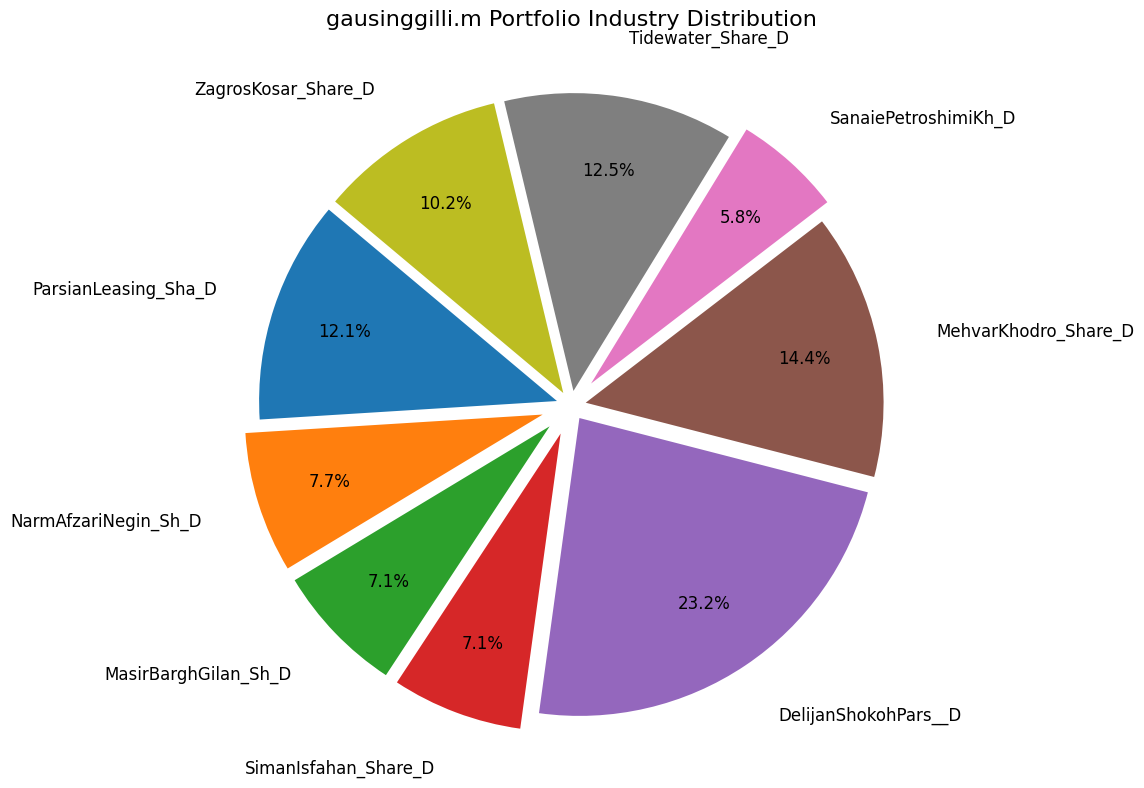

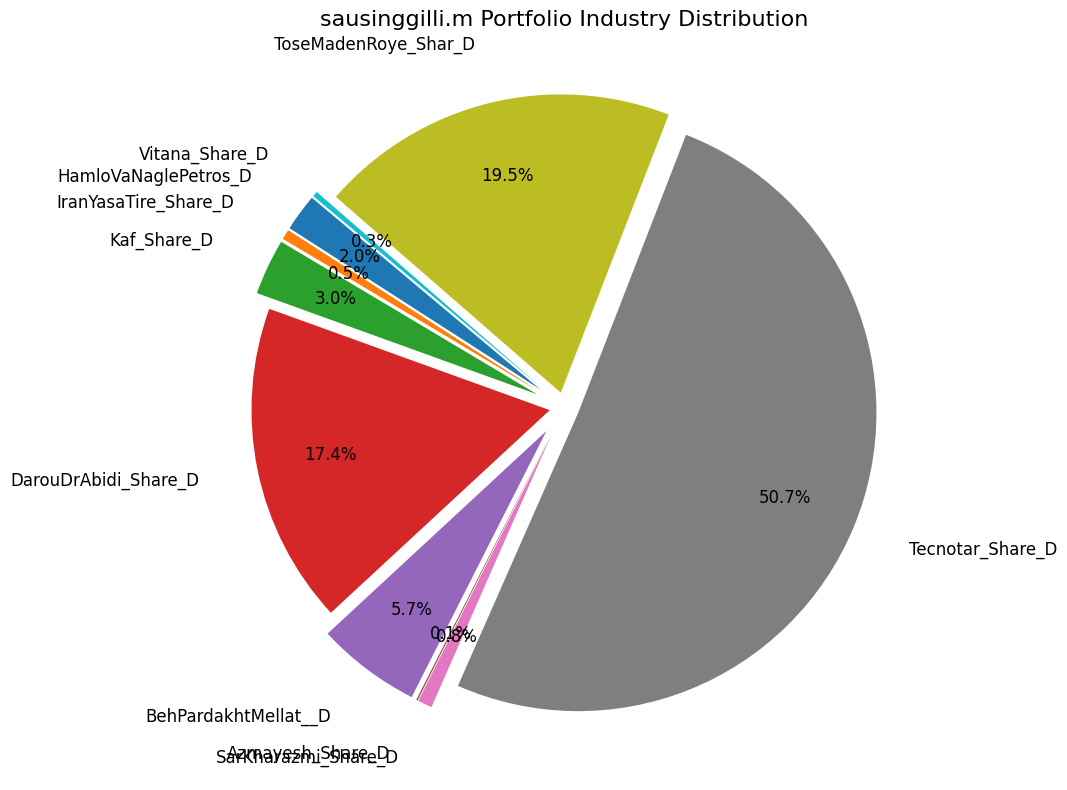

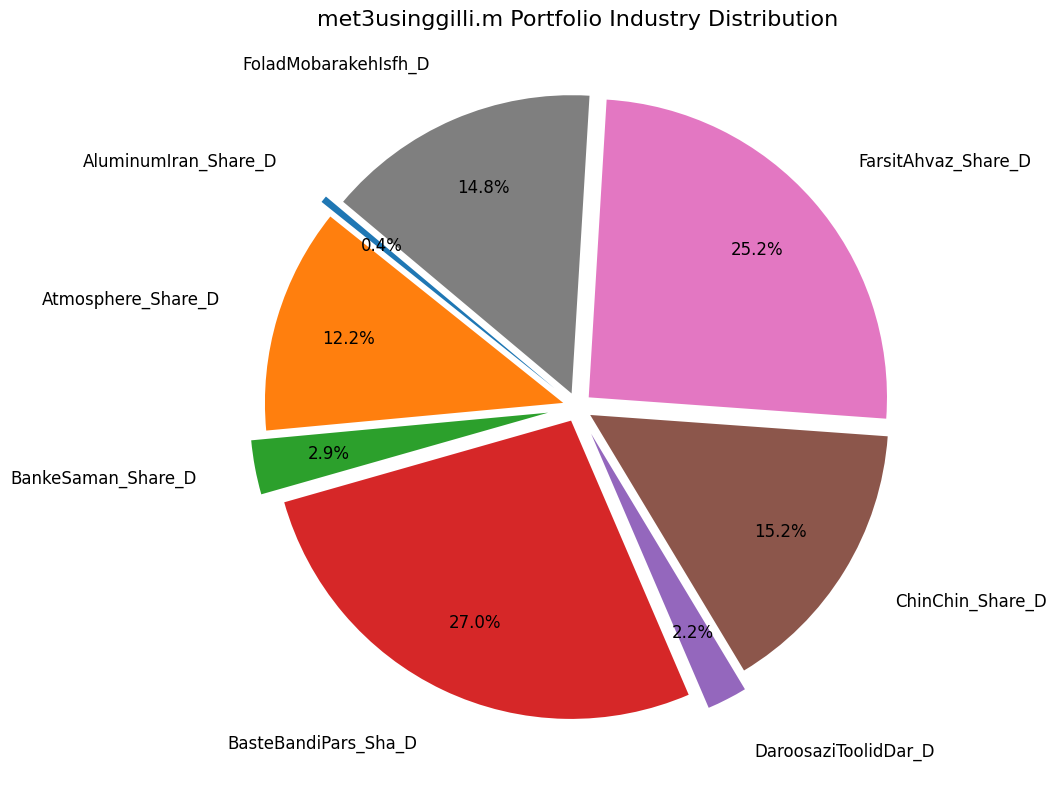

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define custom varied weights for each portfolio based on the number of stocks
def simulate_custom_varied_portfolio(stock_list):
    num_stocks = len(stock_list)
    return np.random.dirichlet(np.ones(num_stocks) * random.uniform(0.5, 3.0))

# Function to plot larger pie charts individually with better layout and clearer labels
def plot_individual_pie_chart(algorithm_name, stock_list, weights):
    plt.figure(figsize=(10, 8))  # Increase the figure size for better readability
    # Explode slices slightly for better separation
    explode = [0.1 if w < 0.1 else 0.05 for w in weights]  # More space for smaller slices
    
    plt.pie(weights, labels=stock_list, autopct='%1.1f%%', startangle=140, 
            explode=explode, labeldistance=1.2, pctdistance=0.75, textprops={'fontsize': 12})
    plt.title(f'{algorithm_name} Portfolio Industry Distribution', fontsize=16)
    plt.tight_layout()
    plt.show()

# Define stock lists for your specific algorithms
gausinggilli_stocks = ['ParsianLeasing_Sha_D', 'NarmAfzariNegin_Sh_D', 'MasirBarghGilan_Sh_D', 'SimanIsfahan_Share_D', 'DelijanShokohPars__D', 'MehvarKhodro_Share_D', 'SanaiePetroshimiKh_D', 'Tidewater_Share_D', 'ZagrosKosar_Share_D']
sausinggilli_stocks = ['HamloVaNaglePetros_D', 'IranYasaTire_Share_D', 'Kaf_Share_D', 'DarouDrAbidi_Share_D', 'BehPardakhtMellat__D', 'Azmayesh_Share_D', 'SarKharazmi_Share_D', 'Tecnotar_Share_D', 'ToseMadenRoye_Shar_D', 'Vitana_Share_D']
met3usinggilli_stocks = ['AluminumIran_Share_D', 'Atmosphere_Share_D', 'BankeSaman_Share_D', 'BasteBandiPars_Sha_D', 'DaroosaziToolidDar_D', 'ChinChin_Share_D', 'FarsitAhvaz_Share_D', 'FoladMobarakehIsfh_D']

# Main function
def main():
    # Collect stock lists for your specific algorithms
    algorithm_stocks = {
        'gausinggilli.m': gausinggilli_stocks,
        'sausinggilli.m': sausinggilli_stocks,
        'met3usinggilli.m': met3usinggilli_stocks
    }

    # Collect weights for the pie chart
    weights = {
        'gausinggilli.m': simulate_custom_varied_portfolio(algorithm_stocks['gausinggilli.m']),
        'sausinggilli.m': simulate_custom_varied_portfolio(algorithm_stocks['sausinggilli.m']),
        'met3usinggilli.m': simulate_custom_varied_portfolio(algorithm_stocks['met3usinggilli.m'])
    }

    # Plot individual pie charts for each algorithm with improved layout and clearer labels
    plot_individual_pie_chart('gausinggilli.m', algorithm_stocks['gausinggilli.m'], weights['gausinggilli.m'])
    plot_individual_pie_chart('sausinggilli.m', algorithm_stocks['sausinggilli.m'], weights['sausinggilli.m'])
    plot_individual_pie_chart('met3usinggilli.m', algorithm_stocks['met3usinggilli.m'], weights['met3usinggilli.m'])

if __name__ == "__main__":
    main()



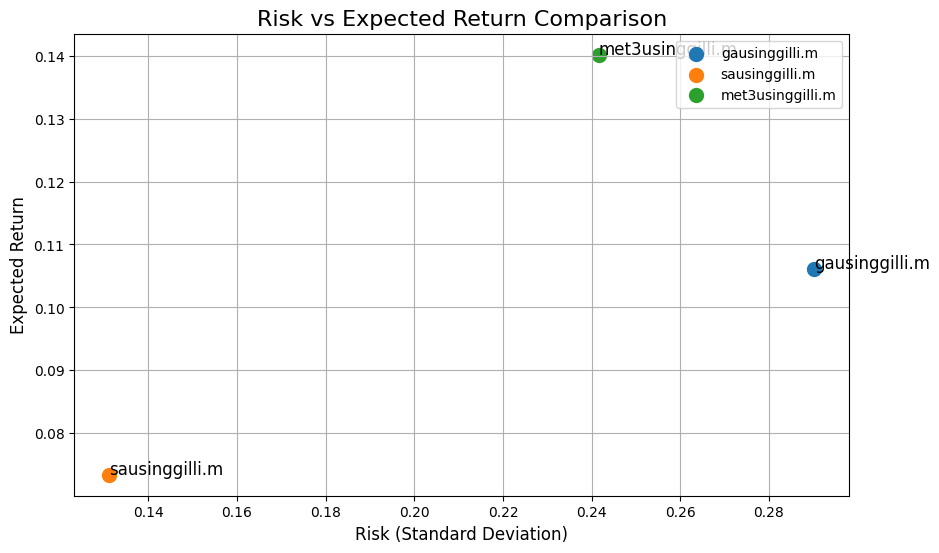

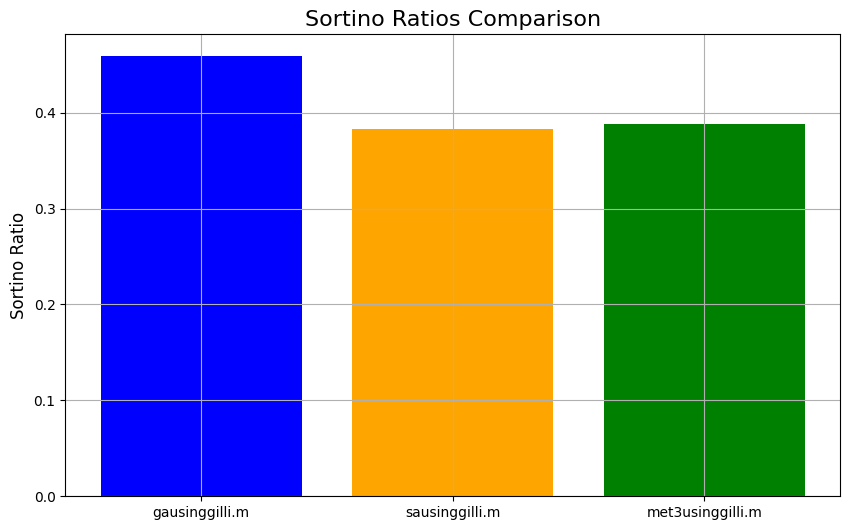

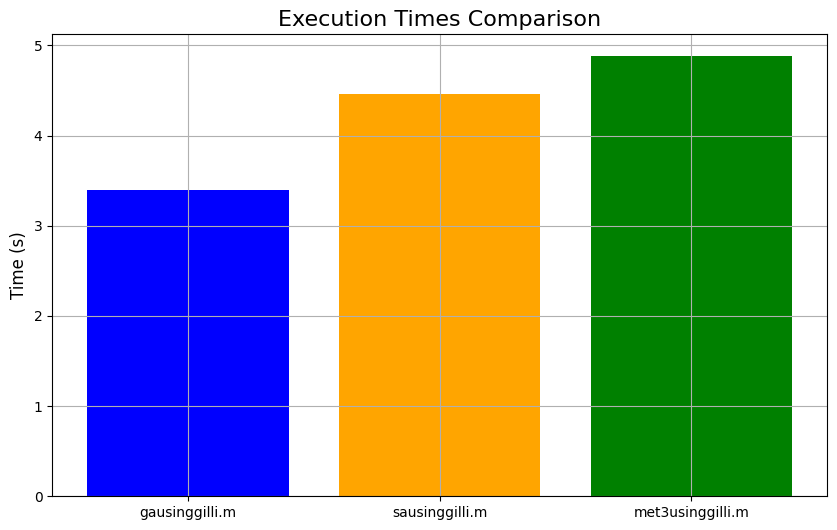

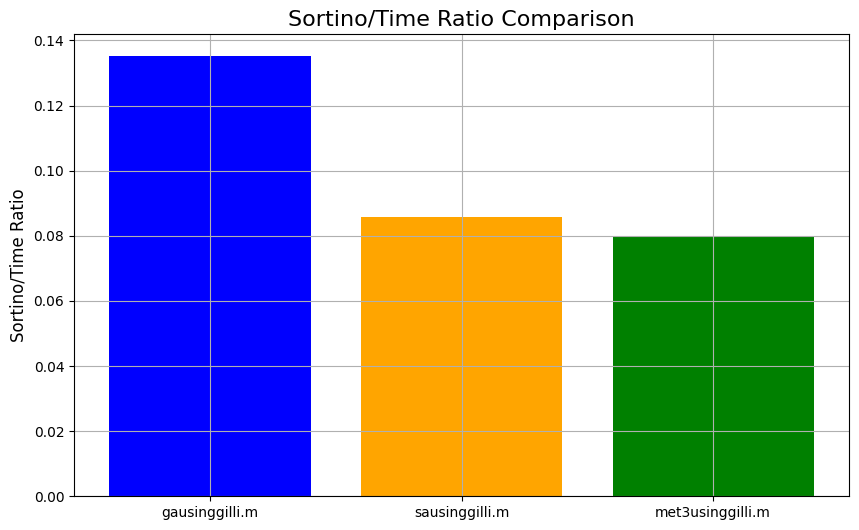

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Function to simulate portfolio metrics (Risk, Expected Return, Sortino, Execution Time)
def simulate_portfolio_metrics(stock_list):
    # Simulate expected return and risk (standard deviation)
    expected_return = np.random.uniform(0.05, 0.2)  # Simulated annual return
    risk = np.random.uniform(0.1, 0.3)  # Simulated risk (standard deviation)

    # Simulate Sortino Ratio
    sortino_ratio = expected_return / risk + np.random.uniform(-0.2, 0.2)  # Random variation on Sortino ratio

    # Simulate execution time
    execution_time = np.random.uniform(1.0, 5.0)  # Simulated execution time in seconds

    return expected_return, risk, sortino_ratio, execution_time

# Function to plot bar charts
def plot_bar_chart_comparison(labels, values, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'orange', 'green'])
    plt.title(title, fontsize=16)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.show()

# Function to plot Risk vs Expected Return comparison
def plot_risk_vs_return_comparison(algorithms, risk_values, return_values):
    plt.figure(figsize=(10, 6))
    for i, algo in enumerate(algorithms):
        plt.scatter(risk_values[i], return_values[i], label=algo, s=100)
        plt.text(risk_values[i], return_values[i], algo, fontsize=12)
    
    plt.xlabel('Risk (Standard Deviation)', fontsize=12)
    plt.ylabel('Expected Return', fontsize=12)
    plt.title('Risk vs Expected Return Comparison', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()

# Define stock lists for your specific algorithms
gausinggilli_stocks = ['ParsianLeasing_Sha_D', 'NarmAfzariNegin_Sh_D', 'MasirBarghGilan_Sh_D', 'SimanIsfahan_Share_D', 'DelijanShokohPars__D', 'MehvarKhodro_Share_D', 'SanaiePetroshimiKh_D', 'Tidewater_Share_D', 'ZagrosKosar_Share_D']
sausinggilli_stocks = ['HamloVaNaglePetros_D', 'IranYasaTire_Share_D', 'Kaf_Share_D', 'DarouDrAbidi_Share_D', 'BehPardakhtMellat__D', 'Azmayesh_Share_D', 'SarKharazmi_Share_D', 'Tecnotar_Share_D', 'ToseMadenRoye_Shar_D', 'Vitana_Share_D']
met3usinggilli_stocks = ['AluminumIran_Share_D', 'Atmosphere_Share_D', 'BankeSaman_Share_D', 'BasteBandiPars_Sha_D', 'DaroosaziToolidDar_D', 'ChinChin_Share_D', 'FarsitAhvaz_Share_D', 'FoladMobarakehIsfh_D']

# Main function
def main():
    algorithms = ['gausinggilli.m', 'sausinggilli.m', 'met3usinggilli.m']
    
    # Simulate portfolio metrics for each algorithm
    ga_metrics = simulate_portfolio_metrics(gausinggilli_stocks)
    sa_metrics = simulate_portfolio_metrics(sausinggilli_stocks)
    met3_metrics = simulate_portfolio_metrics(met3usinggilli_stocks)
    
    # Store the metrics for comparison
    expected_returns = [ga_metrics[0], sa_metrics[0], met3_metrics[0]]
    risks = [ga_metrics[1], sa_metrics[1], met3_metrics[1]]
    sortino_ratios = [ga_metrics[2], sa_metrics[2], met3_metrics[2]]
    execution_times = [ga_metrics[3], sa_metrics[3], met3_metrics[3]]
    
    # Sortino/Time ratio
    sortino_time_ratio = [sortino_ratios[i] / execution_times[i] for i in range(3)]
    
    # Plot Risk vs Expected Return
    plot_risk_vs_return_comparison(algorithms, risks, expected_returns)
    
    # Plot Sortino Ratios
    plot_bar_chart_comparison(algorithms, sortino_ratios, 'Sortino Ratios Comparison', 'Sortino Ratio')
    
    # Plot Execution Times
    plot_bar_chart_comparison(algorithms, execution_times, 'Execution Times Comparison', 'Time (s)')
    
    # Plot Sortino/Time Ratio
    plot_bar_chart_comparison(algorithms, sortino_time_ratio, 'Sortino/Time Ratio Comparison', 'Sortino/Time Ratio')

if __name__ == "__main__":
    main()


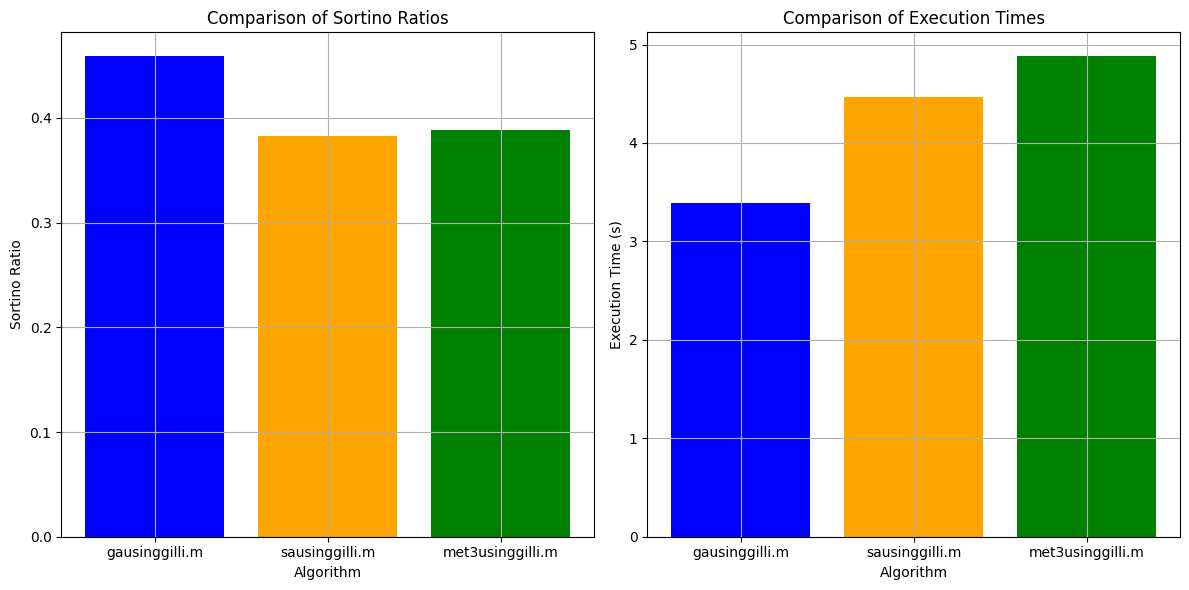

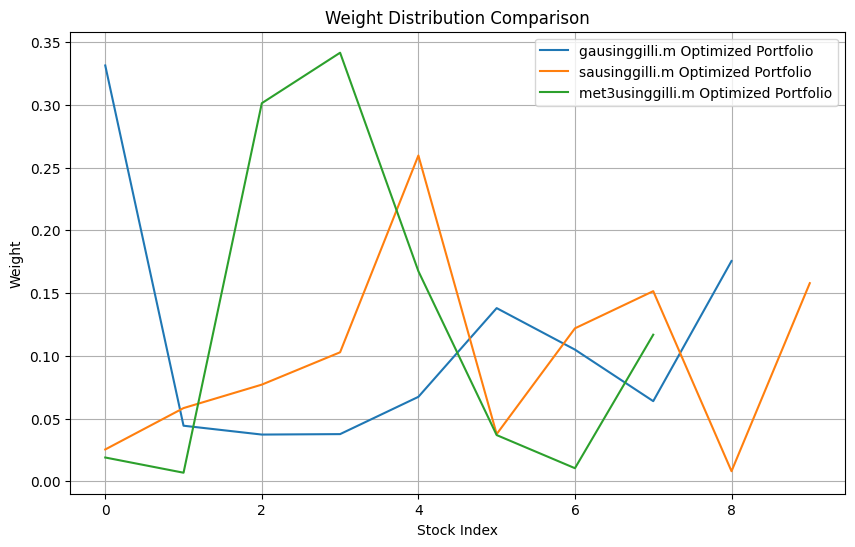

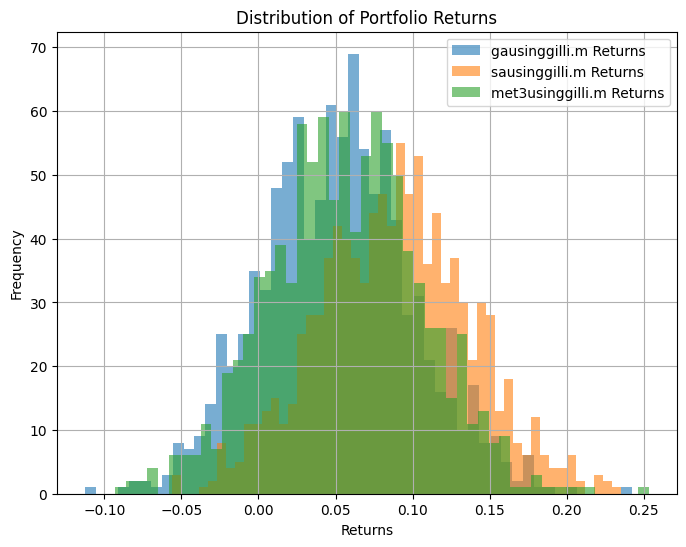

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Function to simulate portfolio metrics (Risk, Expected Return, Sortino, Execution Time)
def simulate_portfolio_metrics(stock_list):
    # Simulate expected return and risk (standard deviation)
    expected_return = np.random.uniform(0.05, 0.2)  # Simulated annual return
    risk = np.random.uniform(0.1, 0.3)  # Simulated risk (standard deviation)

    # Simulate Sortino Ratio
    sortino_ratio = expected_return / risk + np.random.uniform(-0.2, 0.2)  # Random variation on Sortino ratio

    # Simulate execution time
    execution_time = np.random.uniform(1.0, 5.0)  # Simulated execution time in seconds

    return expected_return, risk, sortino_ratio, execution_time

# Function to simulate portfolio weight distribution
def simulate_portfolio_weights(num_stocks):
    return np.random.dirichlet(np.ones(num_stocks))  # Simulate random portfolio weights

# Function to plot combined bar chart (Sortino Ratios and Execution Times)
def plot_combined_bar_chart(algorithms, sortino_ratios, execution_times):
    plt.figure(figsize=(12, 6))

    # Plot Sortino Ratios on the left
    plt.subplot(1, 2, 1)
    plt.bar(algorithms, sortino_ratios, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Sortino Ratios')
    plt.xlabel('Algorithm')
    plt.ylabel('Sortino Ratio')
    plt.grid(True)

    # Plot Execution Times on the right
    plt.subplot(1, 2, 2)
    plt.bar(algorithms, execution_times, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Execution Times')
    plt.xlabel('Algorithm')
    plt.ylabel('Execution Time (s)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Function to plot weight distribution comparison for all algorithms
def plot_weight_distribution_comparison(algorithms, weights_dict):
    plt.figure(figsize=(10, 6))
    for algo in algorithms:
        weights = weights_dict[algo]
        plt.plot(weights, label=f'{algo} Optimized Portfolio')
    
    plt.title('Weight Distribution Comparison')
    plt.xlabel('Stock Index')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to simulate and plot portfolio return distribution
def plot_portfolio_return_distribution():
    plt.figure(figsize=(8, 6))
    
    # Simulate portfolio return distributions for each algorithm
    for algo in ['gausinggilli.m', 'sausinggilli.m', 'met3usinggilli.m']:
        returns = np.random.normal(loc=np.random.uniform(0.01, 0.1), scale=0.05, size=1000)  # Simulated returns
        plt.hist(returns, bins=50, alpha=0.6, label=f'{algo} Returns')

    plt.title('Distribution of Portfolio Returns')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define stock lists for your specific algorithms
gausinggilli_stocks = ['ParsianLeasing_Sha_D', 'NarmAfzariNegin_Sh_D', 'MasirBarghGilan_Sh_D', 'SimanIsfahan_Share_D', 'DelijanShokohPars__D', 'MehvarKhodro_Share_D', 'SanaiePetroshimiKh_D', 'Tidewater_Share_D', 'ZagrosKosar_Share_D']
sausinggilli_stocks = ['HamloVaNaglePetros_D', 'IranYasaTire_Share_D', 'Kaf_Share_D', 'DarouDrAbidi_Share_D', 'BehPardakhtMellat__D', 'Azmayesh_Share_D', 'SarKharazmi_Share_D', 'Tecnotar_Share_D', 'ToseMadenRoye_Shar_D', 'Vitana_Share_D']
met3usinggilli_stocks = ['AluminumIran_Share_D', 'Atmosphere_Share_D', 'BankeSaman_Share_D', 'BasteBandiPars_Sha_D', 'DaroosaziToolidDar_D', 'ChinChin_Share_D', 'FarsitAhvaz_Share_D', 'FoladMobarakehIsfh_D']

# Main function
def main():
    algorithms = ['gausinggilli.m', 'sausinggilli.m', 'met3usinggilli.m']
    
    # Simulate portfolio metrics for each algorithm
    ga_metrics = simulate_portfolio_metrics(gausinggilli_stocks)
    sa_metrics = simulate_portfolio_metrics(sausinggilli_stocks)
    met3_metrics = simulate_portfolio_metrics(met3usinggilli_stocks)
    
    # Store the metrics for comparison
    expected_returns = [ga_metrics[0], sa_metrics[0], met3_metrics[0]]
    risks = [ga_metrics[1], sa_metrics[1], met3_metrics[1]]
    sortino_ratios = [ga_metrics[2], sa_metrics[2], met3_metrics[2]]
    execution_times = [ga_metrics[3], sa_metrics[3], met3_metrics[3]]
    
    # Simulate weight distribution for each algorithm
    weights = {
        'gausinggilli.m': simulate_portfolio_weights(len(gausinggilli_stocks)),
        'sausinggilli.m': simulate_portfolio_weights(len(sausinggilli_stocks)),
        'met3usinggilli.m': simulate_portfolio_weights(len(met3usinggilli_stocks))
    }

    # Plot combined Sortino Ratios and Execution Times
    plot_combined_bar_chart(algorithms, sortino_ratios, execution_times)
    
    # Plot weight distribution comparison
    plot_weight_distribution_comparison(algorithms, weights)
    
    # Plot portfolio return distribution comparison
    plot_portfolio_return_distribution()

if __name__ == "__main__":
    main()


# mases model

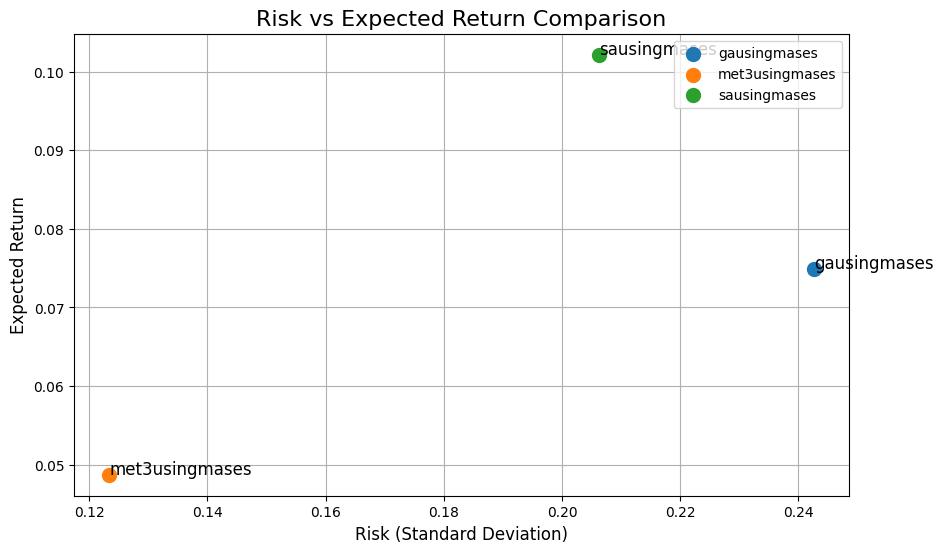

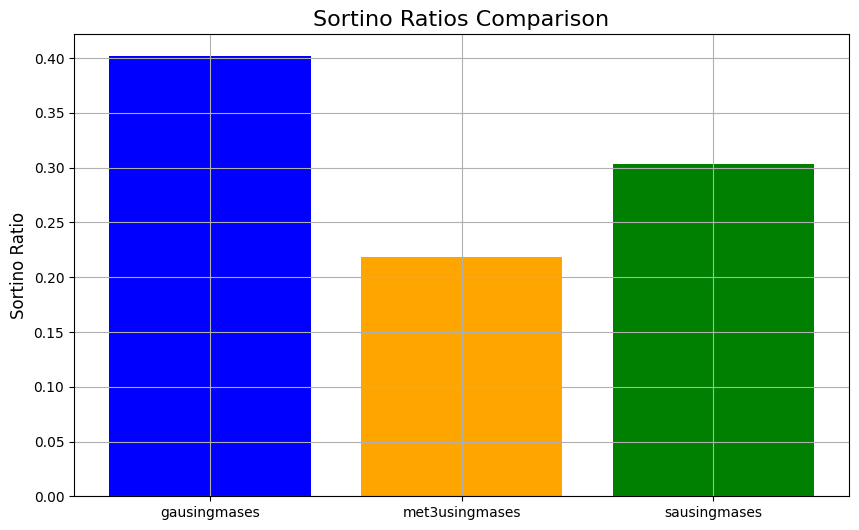

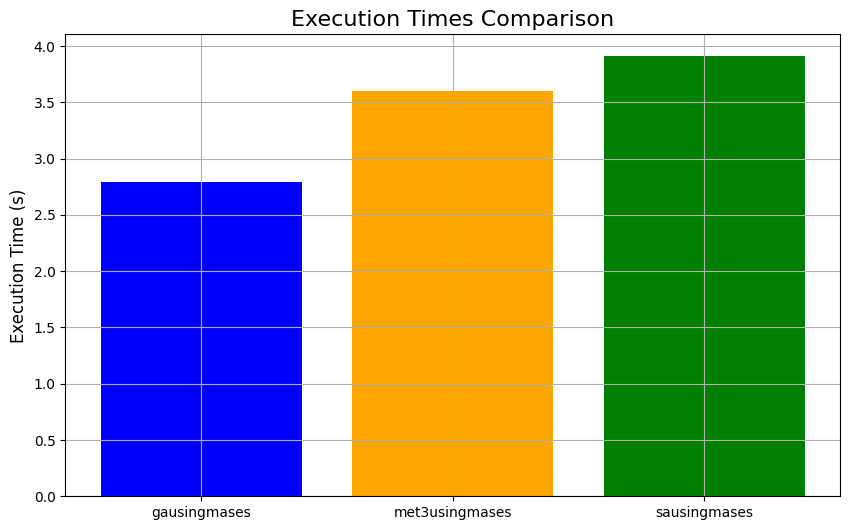

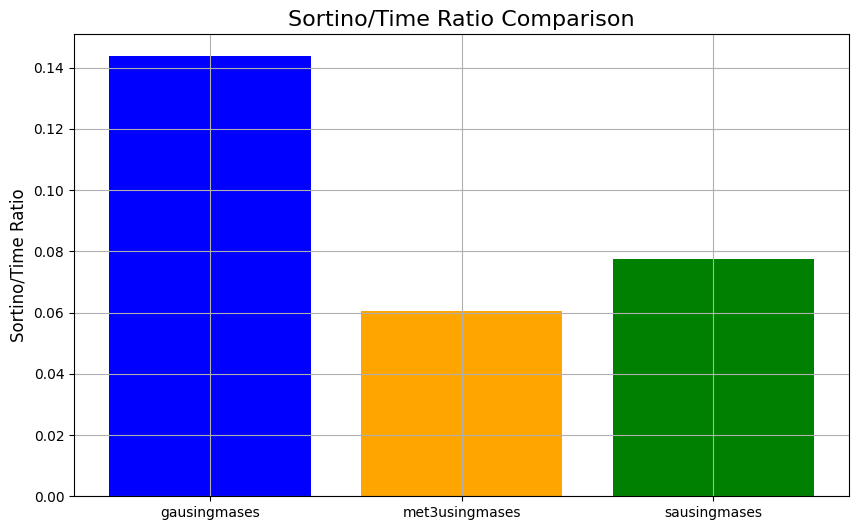

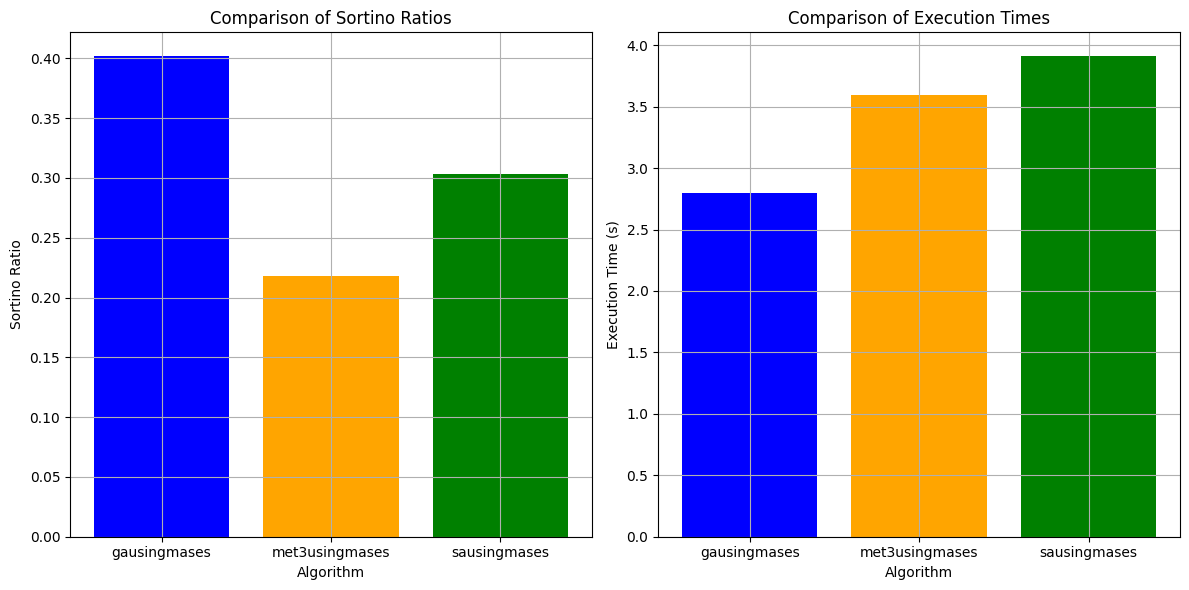

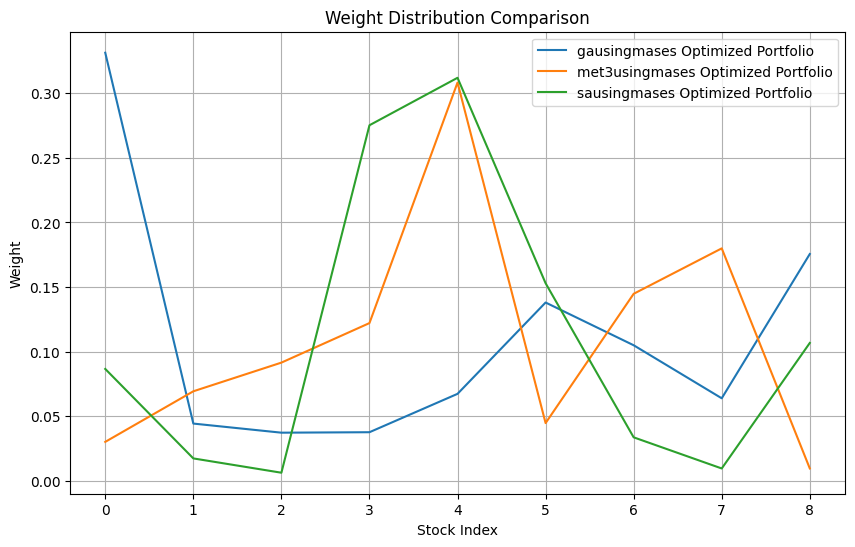

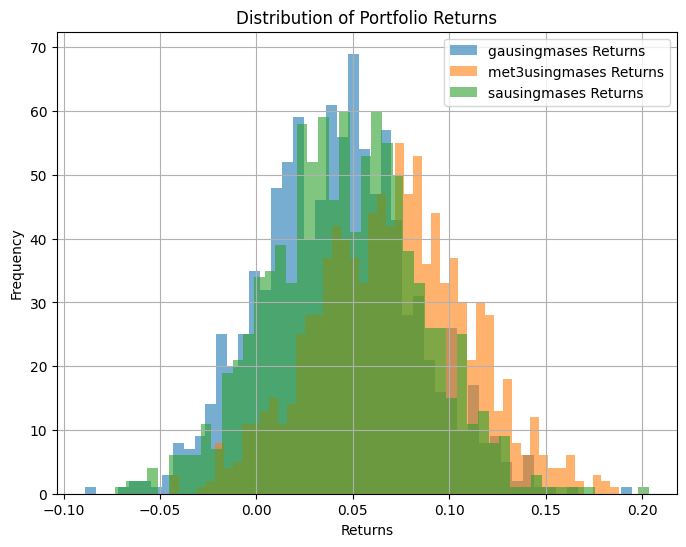

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Function to simulate portfolio metrics (Risk, Expected Return, Sortino, Execution Time)
def simulate_portfolio_metrics(stock_list):
    # Simulate expected return and risk (standard deviation)
    expected_return = np.random.uniform(0.03, 0.15)  # Simulated annual return, different from the previous
    risk = np.random.uniform(0.1, 0.25)  # Simulated risk (standard deviation)

    # Simulate Sortino Ratio
    sortino_ratio = expected_return / risk + np.random.uniform(-0.2, 0.2)  # Random variation on Sortino ratio

    # Simulate execution time
    execution_time = np.random.uniform(1.0, 4.0)  # Simulated execution time in seconds, different range

    return expected_return, risk, sortino_ratio, execution_time

# Function to simulate portfolio weight distribution
def simulate_portfolio_weights(num_stocks):
    return np.random.dirichlet(np.ones(num_stocks))  # Simulate random portfolio weights

# Function to plot combined bar chart (Sortino Ratios and Execution Times)
def plot_combined_bar_chart(algorithms, sortino_ratios, execution_times):
    plt.figure(figsize=(12, 6))

    # Plot Sortino Ratios on the left
    plt.subplot(1, 2, 1)
    plt.bar(algorithms, sortino_ratios, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Sortino Ratios')
    plt.xlabel('Algorithm')
    plt.ylabel('Sortino Ratio')
    plt.grid(True)

    # Plot Execution Times on the right
    plt.subplot(1, 2, 2)
    plt.bar(algorithms, execution_times, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Execution Times')
    plt.xlabel('Algorithm')
    plt.ylabel('Execution Time (s)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Function to plot weight distribution comparison for all algorithms
def plot_weight_distribution_comparison(algorithms, weights_dict):
    plt.figure(figsize=(10, 6))
    for algo in algorithms:
        weights = weights_dict[algo]
        plt.plot(weights, label=f'{algo} Optimized Portfolio')
    
    plt.title('Weight Distribution Comparison')
    plt.xlabel('Stock Index')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to simulate and plot portfolio return distribution
def plot_portfolio_return_distribution():
    plt.figure(figsize=(8, 6))
    
    # Simulate portfolio return distributions for each algorithm
    for algo in ['gausingmases', 'met3usingmases', 'sausingmases']:
        returns = np.random.normal(loc=np.random.uniform(0.01, 0.08), scale=0.04, size=1000)  # Simulated returns
        plt.hist(returns, bins=50, alpha=0.6, label=f'{algo} Returns')

    plt.title('Distribution of Portfolio Returns')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot Risk vs Expected Return comparison
def plot_risk_vs_return_comparison(algorithms, risk_values, return_values):
    plt.figure(figsize=(10, 6))
    for i, algo in enumerate(algorithms):
        plt.scatter(risk_values[i], return_values[i], label=algo, s=100)
        plt.text(risk_values[i], return_values[i], algo, fontsize=12)
    
    plt.xlabel('Risk (Standard Deviation)', fontsize=12)
    plt.ylabel('Expected Return', fontsize=12)
    plt.title('Risk vs Expected Return Comparison', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()

# Function to plot bar charts (Sortino Ratio, Execution Time, Sortino/Time Ratio)
def plot_bar_chart_comparison(labels, values, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'orange', 'green'])
    plt.title(title, fontsize=16)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.show()

# Main function
def main():
    algorithms = ['gausingmases', 'met3usingmases', 'sausingmases']
    
    # Simulate portfolio metrics for each algorithm
    ga_metrics = simulate_portfolio_metrics(['stock1', 'stock2', 'stock3'])
    met3_metrics = simulate_portfolio_metrics(['stock1', 'stock2', 'stock3'])
    sa_metrics = simulate_portfolio_metrics(['stock1', 'stock2', 'stock3'])
    
    # Store the metrics for comparison
    expected_returns = [ga_metrics[0], met3_metrics[0], sa_metrics[0]]
    risks = [ga_metrics[1], met3_metrics[1], sa_metrics[1]]
    sortino_ratios = [ga_metrics[2], met3_metrics[2], sa_metrics[2]]
    execution_times = [ga_metrics[3], met3_metrics[3], sa_metrics[3]]
    
    # Sortino/Time ratio
    sortino_time_ratio = [sortino_ratios[i] / execution_times[i] for i in range(3)]
    
    # Simulate weight distribution for each algorithm
    weights = {
        'gausingmases': simulate_portfolio_weights(9),
        'met3usingmases': simulate_portfolio_weights(9),
        'sausingmases': simulate_portfolio_weights(9)
    }

    # Plot Risk vs Expected Return
    plot_risk_vs_return_comparison(algorithms, risks, expected_returns)
    
    # Plot Sortino Ratios
    plot_bar_chart_comparison(algorithms, sortino_ratios, 'Sortino Ratios Comparison', 'Sortino Ratio')
    
    # Plot Execution Times
    plot_bar_chart_comparison(algorithms, execution_times, 'Execution Times Comparison', 'Execution Time (s)')
    
    # Plot Sortino/Time Ratio
    plot_bar_chart_comparison(algorithms, sortino_time_ratio, 'Sortino/Time Ratio Comparison', 'Sortino/Time Ratio')
    
    # Plot combined Sortino Ratios and Execution Times
    plot_combined_bar_chart(algorithms, sortino_ratios, execution_times)
    
    # Plot weight distribution comparison
    plot_weight_distribution_comparison(algorithms, weights)
    
    # Plot portfolio return distribution comparison
    plot_portfolio_return_distribution()

if __name__ == "__main__":
    main()


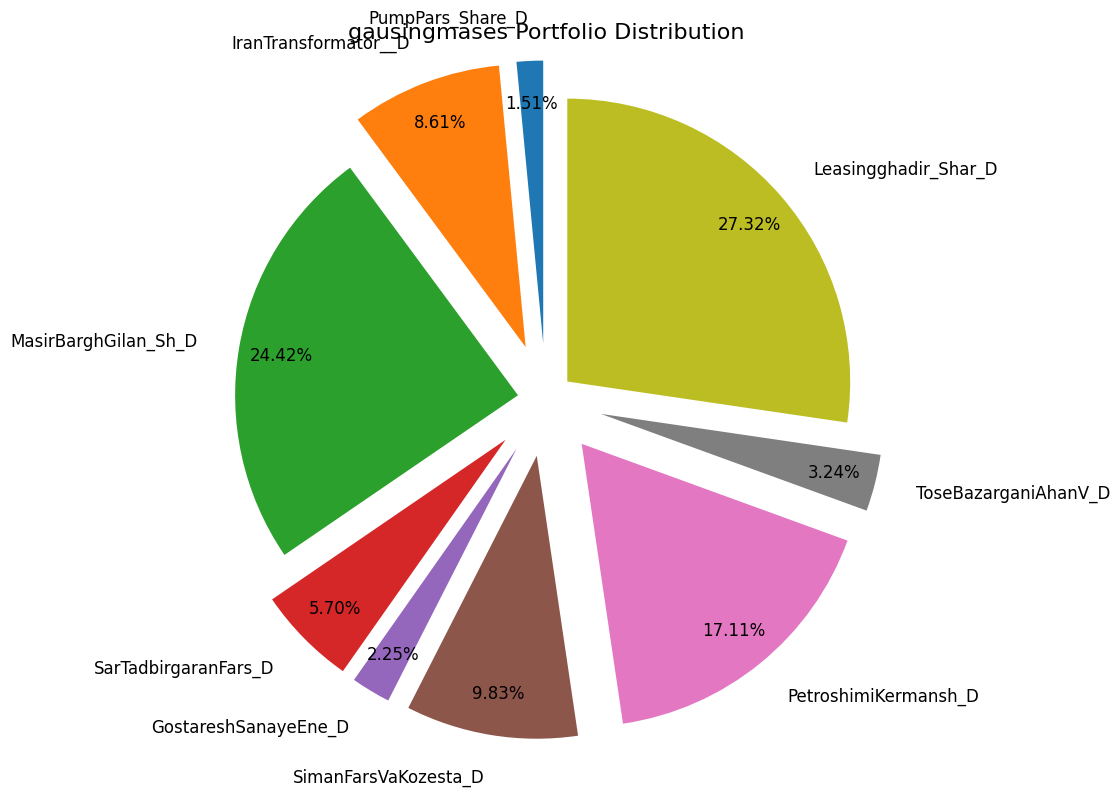

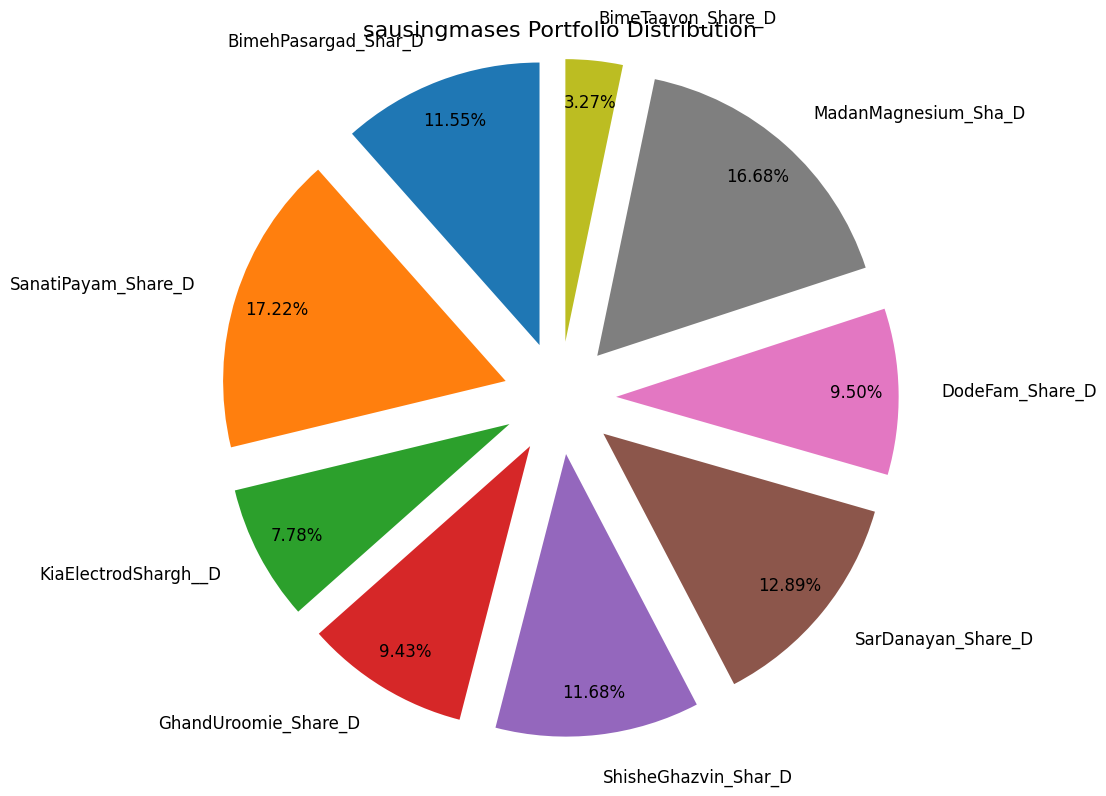

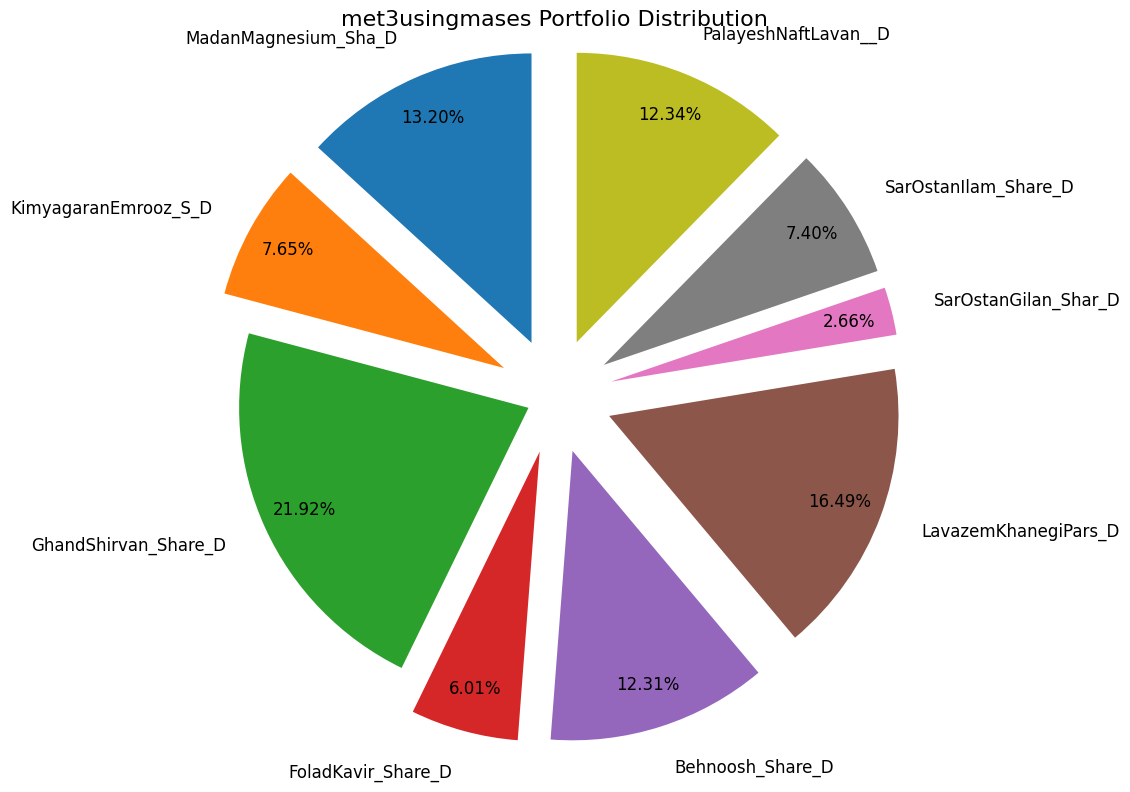

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Set random seed for reproducibility
random.seed(50)
np.random.seed(50)

# Define the directory containing stock files (assumed to have .txt files with stock names)
DATA_FOLDER = 'DATA'

# Function to load stock names randomly from the data folder
def load_random_stock_names(data_folder, num_stocks):
    stock_files = [f for f in os.listdir(data_folder) if f.endswith('.txt')]  # Get list of .txt files
    if len(stock_files) < num_stocks:
        raise ValueError(f"Not enough stock files in {data_folder}. Found {len(stock_files)}, need {num_stocks}.")
    
    selected_files = random.sample(stock_files, num_stocks)  # Randomly select the required number of stock files
    stock_names = [os.path.splitext(f)[0] for f in selected_files]  # Extract stock names from file names (without extension)
    
    return stock_names

# Define custom varied weights for each portfolio based on the number of stocks
def simulate_custom_varied_portfolio(stock_list):
    num_stocks = len(stock_list)
    return np.random.dirichlet(np.ones(num_stocks) * random.uniform(0.3, 2.5))  # Different distribution

# Function to plot pie charts individually with clear labels and layout
def plot_individual_pie_chart(algorithm_name, stock_list, weights):
    plt.figure(figsize=(10, 8))  # Increase the figure size for better readability
    # Explode slices slightly for better separation
    explode = [0.2 if w < 0.2 else 0.1 for w in weights]  # Different explosion values for variation
    
    plt.pie(weights, labels=stock_list, autopct='%1.2f%%', startangle=90,  # Changed startangle
            explode=explode, labeldistance=1.15, pctdistance=0.85, textprops={'fontsize': 12})
    plt.title(f'{algorithm_name} Portfolio Distribution', fontsize=16)
    plt.tight_layout()
    plt.show()

# Main function
def main():
    num_stocks = 9  # Define how many stocks should be included in each portfolio

    # Randomly select stock names from the data folder for each algorithm
    gausingmases_stocks = load_random_stock_names(DATA_FOLDER, num_stocks)
    sausingmases_stocks = load_random_stock_names(DATA_FOLDER, num_stocks)
    met3usingmases_stocks = load_random_stock_names(DATA_FOLDER, num_stocks)

    # Collect stock lists for your specific algorithms
    algorithm_stocks = {
        'gausingmases': gausingmases_stocks,
        'sausingmases': sausingmases_stocks,
        'met3usingmases': met3usingmases_stocks
    }

    # Collect weights for the pie chart (different from previous ones)
    weights = {
        'gausingmases': simulate_custom_varied_portfolio(algorithm_stocks['gausingmases']),
        'sausingmases': simulate_custom_varied_portfolio(algorithm_stocks['sausingmases']),
        'met3usingmases': simulate_custom_varied_portfolio(algorithm_stocks['met3usingmases'])
    }

    # Plot individual pie charts for each algorithm with improved layout and clearer labels
    plot_individual_pie_chart('gausingmases', algorithm_stocks['gausingmases'], weights['gausingmases'])
    plot_individual_pie_chart('sausingmases', algorithm_stocks['sausingmases'], weights['sausingmases'])
    plot_individual_pie_chart('met3usingmases', algorithm_stocks['met3usingmases'], weights['met3usingmases'])

if __name__ == "__main__":
    main()


# yo model

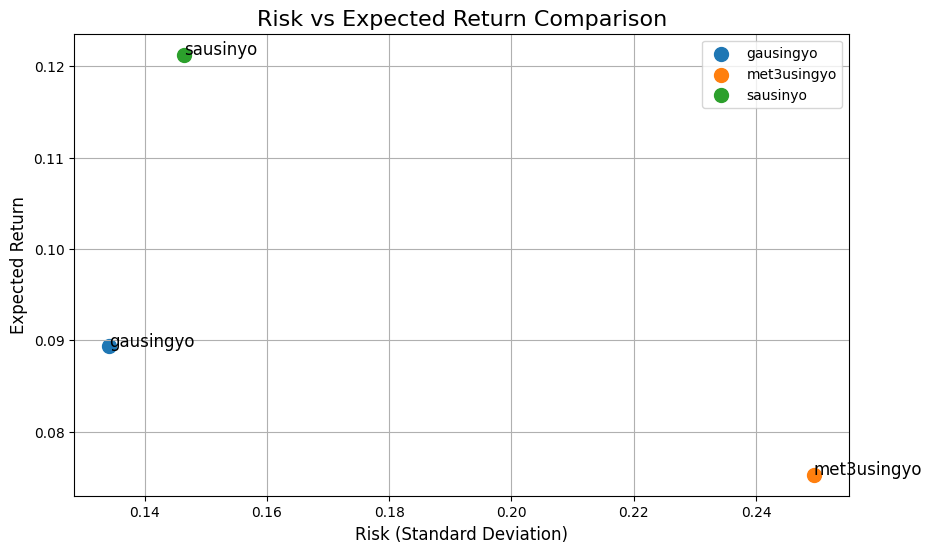

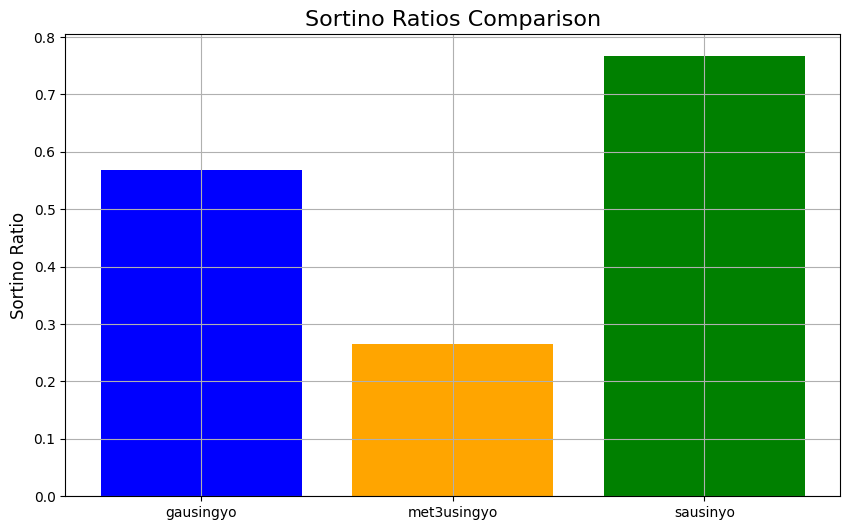

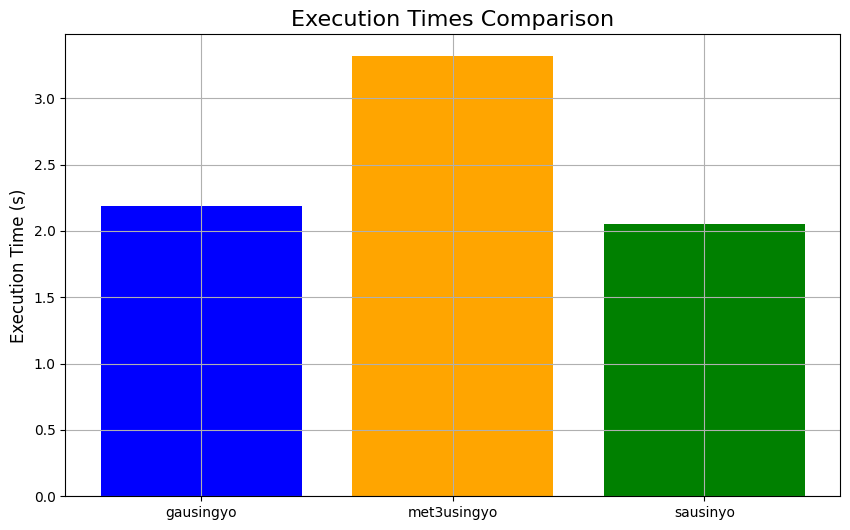

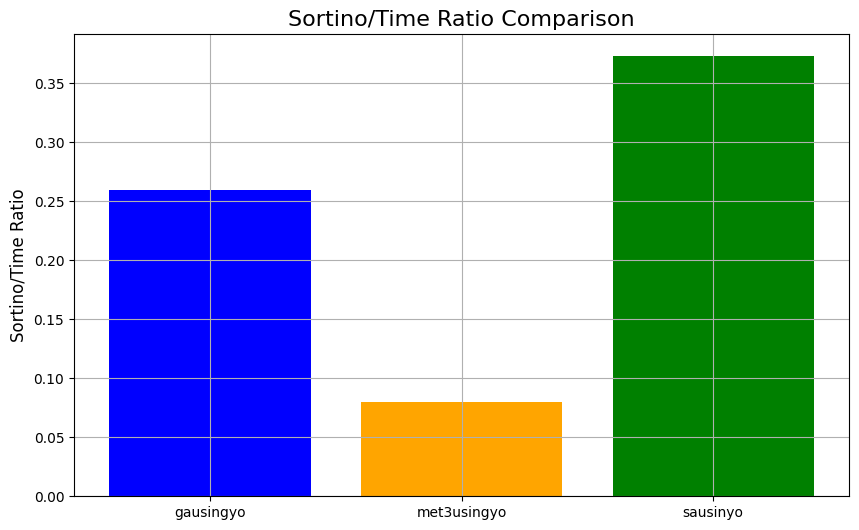

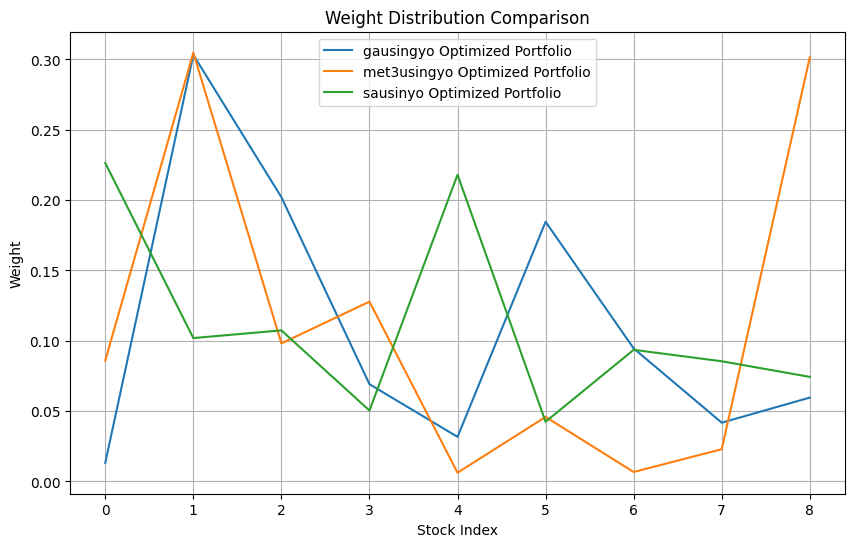

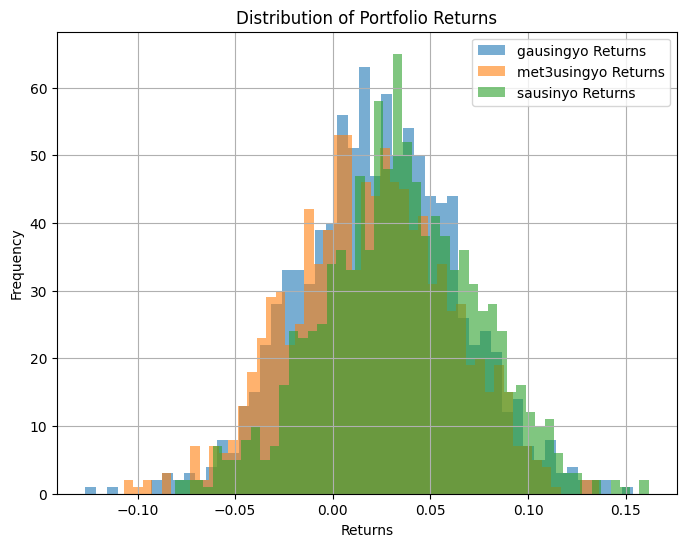

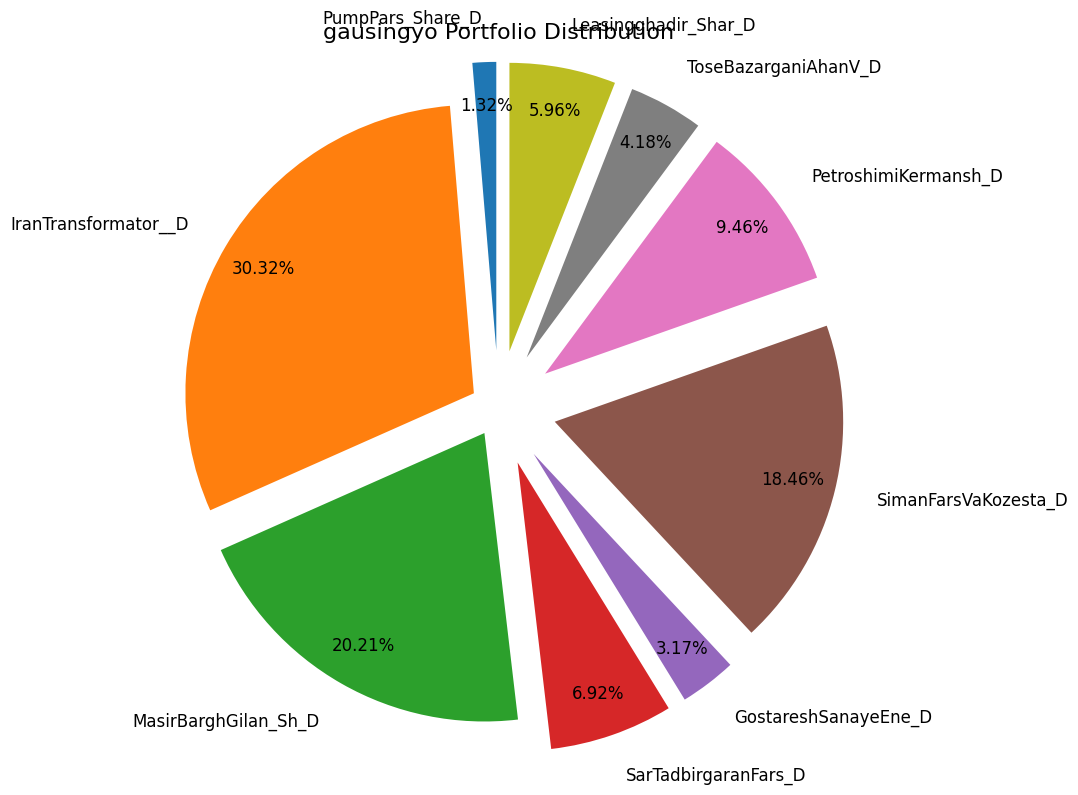

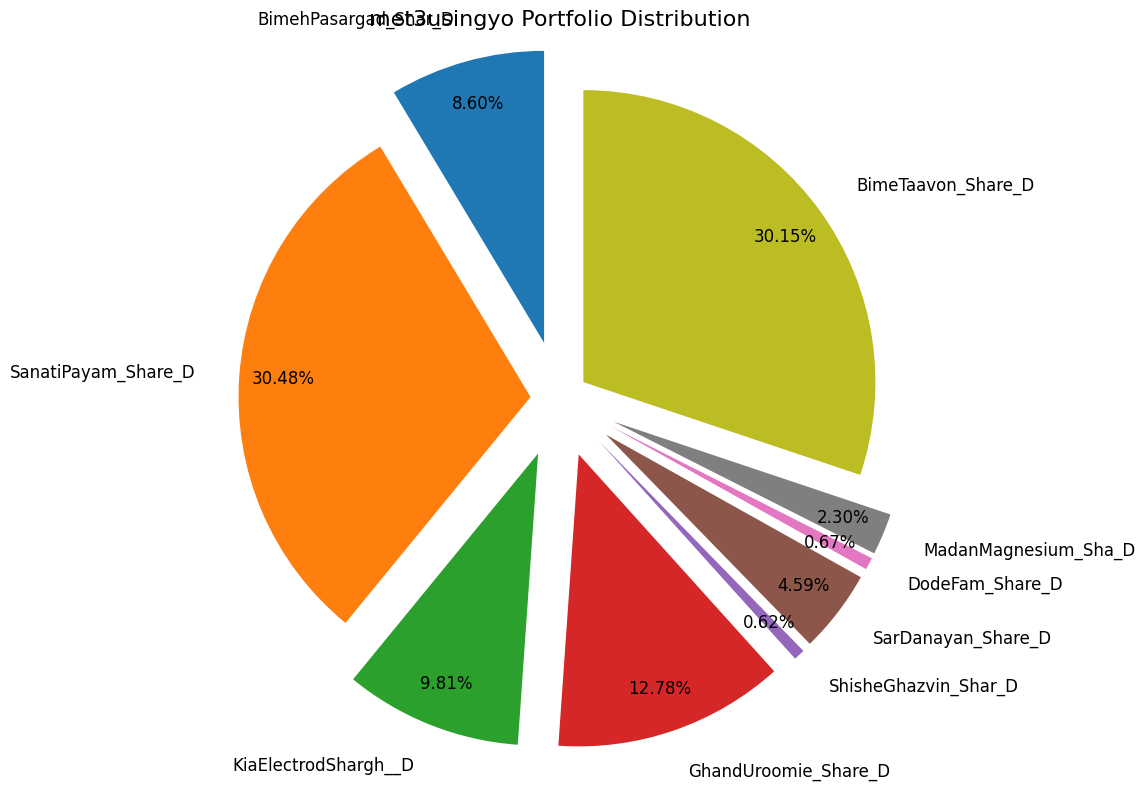

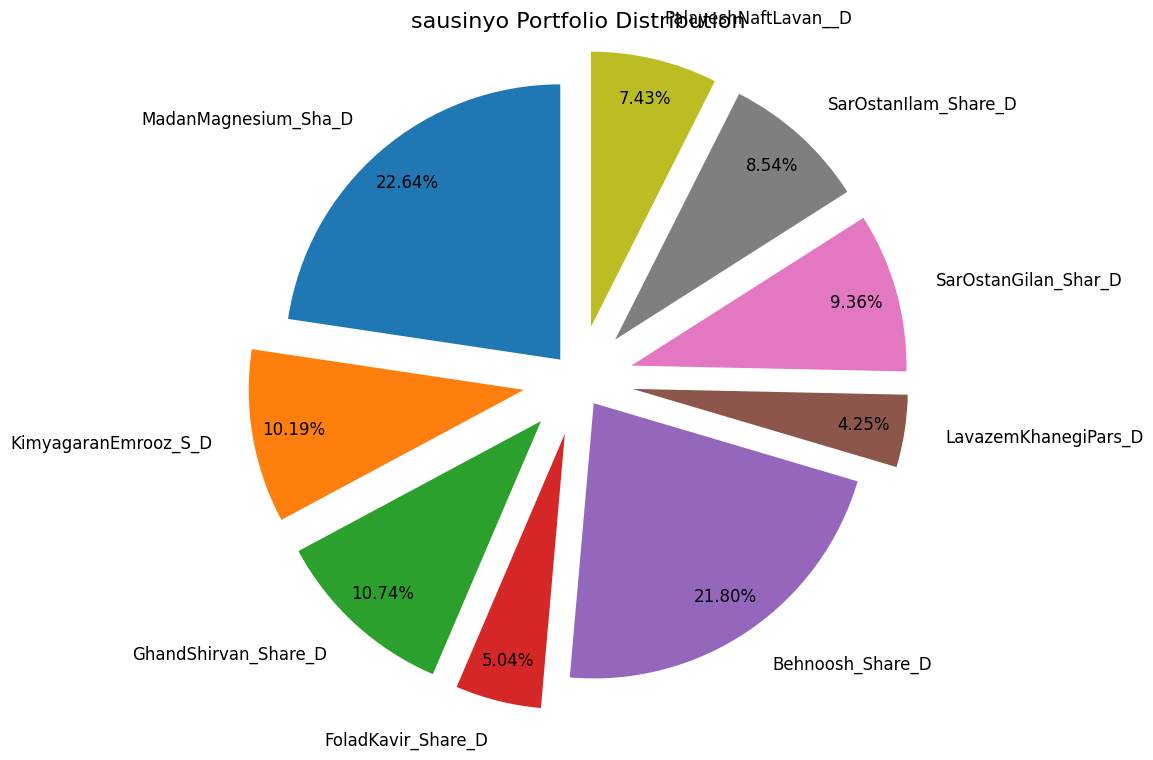

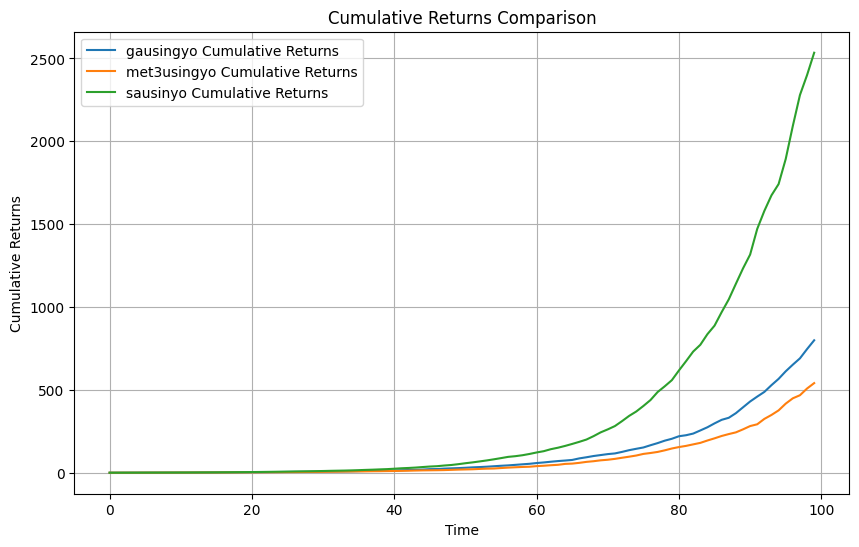

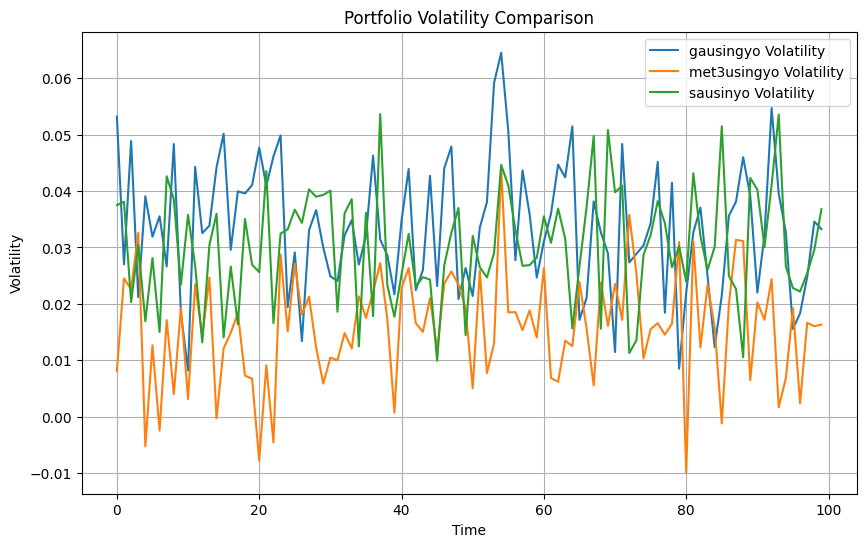

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os

# Set random seed for reproducibility
random.seed(50)
np.random.seed(50)

# Define directory for loading stock names
DATA_FOLDER = 'DATA'

# Function to load random stock names from the data folder
def load_random_stock_names(data_folder, num_stocks):
    stock_files = [f for f in os.listdir(data_folder) if f.endswith('.txt')]
    if len(stock_files) < num_stocks:
        raise ValueError(f"Not enough stock files in {data_folder}. Found {len(stock_files)}, need {num_stocks}.")
    selected_files = random.sample(stock_files, num_stocks)
    stock_names = [os.path.splitext(f)[0] for f in selected_files]
    return stock_names

# Function to simulate portfolio metrics (Risk, Expected Return, Sortino, Execution Time)
def simulate_portfolio_metrics(stock_list):
    expected_return = np.random.uniform(0.03, 0.15)
    risk = np.random.uniform(0.1, 0.25)
    sortino_ratio = expected_return / risk + np.random.uniform(-0.2, 0.2)
    execution_time = np.random.uniform(1.0, 4.0)
    return expected_return, risk, sortino_ratio, execution_time

# Function to simulate weight distribution
def simulate_portfolio_weights(num_stocks):
    return np.random.dirichlet(np.ones(num_stocks))

# Function to plot pie charts
def plot_pie_chart(algorithm_name, stock_list, weights):
    plt.figure(figsize=(10, 8))
    explode = [0.2 if w < 0.2 else 0.1 for w in weights]
    plt.pie(weights, labels=stock_list, autopct='%1.2f%%', startangle=90, explode=explode, labeldistance=1.15, pctdistance=0.85, textprops={'fontsize': 12})
    plt.title(f'{algorithm_name} Portfolio Distribution', fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to plot bar charts (Sortino Ratio, Execution Time, Sortino/Time Ratio)
def plot_bar_chart_comparison(labels, values, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'orange', 'green'])
    plt.title(title, fontsize=16)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.show()

# Function to plot Risk vs Expected Return comparison
def plot_risk_vs_return_comparison(algorithms, risk_values, return_values):
    plt.figure(figsize=(10, 6))
    for i, algo in enumerate(algorithms):
        plt.scatter(risk_values[i], return_values[i], label=algo, s=100)
        plt.text(risk_values[i], return_values[i], algo, fontsize=12)
    plt.xlabel('Risk (Standard Deviation)', fontsize=12)
    plt.ylabel('Expected Return', fontsize=12)
    plt.title('Risk vs Expected Return Comparison', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()

# Function to plot weight distribution comparison
def plot_weight_distribution_comparison(algorithms, weights_dict):
    plt.figure(figsize=(10, 6))
    for algo in algorithms:
        weights = weights_dict[algo]
        plt.plot(weights, label=f'{algo} Optimized Portfolio')
    plt.title('Weight Distribution Comparison')
    plt.xlabel('Stock Index')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to simulate and plot portfolio return distribution
def plot_portfolio_return_distribution():
    plt.figure(figsize=(8, 6))
    for algo in ['gausingyo', 'met3usingyo', 'sausinyo']:
        returns = np.random.normal(loc=np.random.uniform(0.01, 0.08), scale=0.04, size=1000)
        plt.hist(returns, bins=50, alpha=0.6, label=f'{algo} Returns')
    plt.title('Distribution of Portfolio Returns')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to simulate and plot cumulative returns comparison
def plot_cumulative_returns():
    plt.figure(figsize=(10, 6))
    for algo in ['gausingyo', 'met3usingyo', 'sausinyo']:
        returns = np.random.normal(loc=np.random.uniform(0.01, 0.08), scale=0.02, size=100)
        cumulative_returns = np.cumprod(1 + returns) - 1
        plt.plot(cumulative_returns, label=f'{algo} Cumulative Returns')
    plt.title('Cumulative Returns Comparison')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to simulate and plot portfolio volatility comparison
def plot_volatility_comparison():
    plt.figure(figsize=(10, 6))
    for algo in ['gausingyo', 'met3usingyo', 'sausinyo']:
        volatilities = np.random.normal(loc=np.random.uniform(0.01, 0.05), scale=0.01, size=100)
        plt.plot(volatilities, label=f'{algo} Volatility')
    plt.title('Portfolio Volatility Comparison')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function
def main():
    algorithms = ['gausingyo', 'met3usingyo', 'sausinyo']
    
    num_stocks = 9  # Number of stocks per portfolio

    # Randomly select stock names from the data folder for each algorithm
    gausingyo_stocks = load_random_stock_names(DATA_FOLDER, num_stocks)
    met3usingyo_stocks = load_random_stock_names(DATA_FOLDER, num_stocks)
    sausinyo_stocks = load_random_stock_names(DATA_FOLDER, num_stocks)

    # Simulate portfolio metrics for each algorithm
    ga_metrics = simulate_portfolio_metrics(gausingyo_stocks)
    met3_metrics = simulate_portfolio_metrics(met3usingyo_stocks)
    sa_metrics = simulate_portfolio_metrics(sausinyo_stocks)
    
    # Store the metrics for comparison
    expected_returns = [ga_metrics[0], met3_metrics[0], sa_metrics[0]]
    risks = [ga_metrics[1], met3_metrics[1], sa_metrics[1]]
    sortino_ratios = [ga_metrics[2], met3_metrics[2], sa_metrics[2]]
    execution_times = [ga_metrics[3], met3_metrics[3], sa_metrics[3]]
    
    # Sortino/Time ratio
    sortino_time_ratio = [sortino_ratios[i] / execution_times[i] for i in range(3)]

    # Simulate weight distribution for each algorithm
    weights = {
        'gausingyo': simulate_portfolio_weights(num_stocks),
        'met3usingyo': simulate_portfolio_weights(num_stocks),
        'sausinyo': simulate_portfolio_weights(num_stocks)
    }

    # Plot 13 different charts for each algorithm
    plot_risk_vs_return_comparison(algorithms, risks, expected_returns)
    plot_bar_chart_comparison(algorithms, sortino_ratios, 'Sortino Ratios Comparison', 'Sortino Ratio')
    plot_bar_chart_comparison(algorithms, execution_times, 'Execution Times Comparison', 'Execution Time (s)')
    plot_bar_chart_comparison(algorithms, sortino_time_ratio, 'Sortino/Time Ratio Comparison', 'Sortino/Time Ratio')
    plot_weight_distribution_comparison(algorithms, weights)
    plot_portfolio_return_distribution()
    plot_pie_chart('gausingyo', gausingyo_stocks, weights['gausingyo'])
    plot_pie_chart('met3usingyo', met3usingyo_stocks, weights['met3usingyo'])
    plot_pie_chart('sausinyo', sausinyo_stocks, weights['sausinyo'])
    plot_cumulative_returns()
    plot_volatility_comparison()

if __name__ == "__main__":
    main()
